# Common

In [1]:
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch.utils.data as data_utils
import time  
import random
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
#save the time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [5]:
# Copy the dataset to the local environment
!cp "/content/drive/MyDrive/upload_DJIA_table.csv" "DJIA.csv" 

# Load the stock data
#change back to kaggle dataset, however I know it has some problem in it
df_stock = pd.read_csv('DJIA.csv', index_col = "Date")
df_stock.sort_index(axis=0,ascending=True,inplace=True)

#check if close and adj close is ever different
diff_index = []
for row in range(len(df_stock)):
    if df_stock["Close"][row] != df_stock["Adj Close"][row]:
        diff_index.append(row)

if len(diff_index) > 1:
  raise ValueError("DIFFERENT")

# Calculate moving average for 10, 20, 50 days
ma_day = [7, 14, 21]

for ma in ma_day:
  column_name = f"MA for {ma} days"
  df_stock[column_name] = df_stock["Adj Close"].rolling(ma).mean()  

#check volatility with MA and create MA for that
# Visualize the moving averages and volume
# first create standardized input for plot
df_stock_close_std = (df_stock["Close"] - df_stock["Close"].mean())/df_stock["Close"].std()
df_stock_vol_std = (df_stock["Volume"] - df_stock["Volume"].mean())/df_stock["Volume"].std()  

#move averages for volume and plot for them
for ma in ma_day:
  column_name = f"Volume MA for {ma} days"
  df_stock[column_name] = df_stock["Volume"].rolling(ma).mean()

# Visualize the moving averages and volume
# first create std input for plot
df_stock_close_std = (df_stock["Close"] - df_stock["Close"].mean())/df_stock["Close"].std()
df_stock_vol_MA_std = (df_stock["Volume MA for 21 days"] - df_stock["Volume MA for 21 days"].mean())/df_stock["Volume MA for 21 days"].std()  

#calculate the diff volume for the before day
diff_volume = []
for row in range(len(df_stock)):
    if row == 0:
        diff_volume.append(0)
    else:
        diff_volume.append(df_stock["Volume"][row] - df_stock["Volume"][row - 1])

df_stock["Volume diff"] = diff_volume

for ma in ma_day:
  column_name = f"Volume diff MA for {ma} days"
  df_stock[column_name] = df_stock["Volume diff"].rolling(ma).mean()

#volume changes visualization after std
df_stock_vol_diff_std = (df_stock["Volume diff"] - df_stock["Volume diff"].mean())/df_stock["Volume diff"].std()
df_stock_vol_diff_7MA_std = (df_stock["Volume diff MA for 7 days"] - df_stock["Volume diff MA for 7 days"].mean())/df_stock["Volume diff MA for 7 days"].std()
df_stock_vol_diff_14MA_std = (df_stock["Volume diff MA for 14 days"] - df_stock["Volume diff MA for 14 days"].mean())/df_stock["Volume diff MA for 14 days"].std()
df_stock_vol_diff_21MA_std = (df_stock["Volume diff MA for 21 days"] - df_stock["Volume diff MA for 21 days"].mean())/df_stock["Volume diff MA for 21 days"].std()  

#H-L with MA
diff_H_L = []
for row in range(len(df_stock)):
    diff_H_L.append(df_stock["High"][row] - df_stock["Low"][row])

df_stock["High-Low"] = diff_H_L

for ma in ma_day:
  column_name = f"High-Low MA for {ma} days"
  df_stock[column_name] = df_stock["High-Low"].rolling(ma).mean()

#plot H-L std with close values
df_stock_close_std = (df_stock["Close"] - df_stock["Close"].mean())/df_stock["Close"].std()
df_stock_h_l_std = (df_stock["High-Low"] - df_stock["High-Low"].mean())/df_stock["High-Low"].std()
df_stock_h_l_std_7MA_std = (df_stock["Volume diff MA for 7 days"] - df_stock["Volume diff MA for 7 days"].mean())/df_stock["Volume diff MA for 7 days"].std()  

#O-C with MA
diff_O_C = []
for row in range(len(df_stock)):
    diff_O_C.append(df_stock["Open"][row] - df_stock["Close"][row])

df_stock["Open-Close"] = diff_O_C

for ma in ma_day:
  column_name = f"Open-Close MA for {ma} days"
  df_stock[column_name] = df_stock["Open-Close"].rolling(ma).mean()

#plot H-L std with close values
df_stock_close_std = (df_stock["Close"] - df_stock["Close"].mean())/df_stock["Close"].std()
df_stock_o_c_std = (df_stock["Open-Close"] - df_stock["Open-Close"].mean())/df_stock["Open-Close"].std()
df_stock_o_c_std_7MA_std = (df_stock["Open-Close MA for 7 days"] - df_stock["Open-Close MA for 7 days"].mean())/df_stock["Open-Close MA for 7 days"].std()  

#close standard deviation
df_stock["Close 7day deviation"] = df_stock["Close"].rolling(7).std()

#plot colse std std with close values
df_stock_close_std = (df_stock["Close"] - df_stock["Close"].mean())/df_stock["Close"].std()
df_stock_c_std_std = (df_stock["Close 7day deviation"] - df_stock["Close 7day deviation"].mean())/df_stock["Close 7day deviation"].std()

#create input and output data
input_df = pd.DataFrame()
output_df = pd.DataFrame()

#input features:
#   Open
#   High
#   Low
#   Close
#   Volume
#   High - Low
#   Open - Close
#   7 days MA close
#   14 days MA close
#   21 days MA close
#   7 days MA volume
#   7 days std 
input_df["Open"] = df_stock["Open"][24:]
input_df["High"] = df_stock["Open"][24:]
input_df["Low"] = df_stock["Low"][24:]
input_df["Close"] = df_stock["Close"][24:]
input_df["Volume"] = df_stock["Volume"][24:]
input_df["High-Low"] = df_stock["High-Low"][24:]
input_df["Open-Close"] = df_stock["Open-Close"][24:]
input_df["7d MA close"] = df_stock["MA for 7 days"][24:]
input_df["14d MA close"] = df_stock["MA for 14 days"][24:]
input_df["21d MA close"] = df_stock["MA for 21 days"][24:]
input_df["7d MA volume"] = df_stock["Volume diff MA for 7 days"][24:]
input_df["14d std"] = df_stock["Close 7day deviation"][24:]

#output:
#   close for next day
#input start from 24. day and last to last before one,
#output start from 25. day and last to the last
#will drop the rows after std for get the same values
output_df["Next Close"] = df_stock["Close"][24:]

# std the input and output
input_std = (input_df - input_df.mean())/input_df.std()

output_std = (output_df - output_df.mean())/output_df.std()

# drop the input last row
input_std.drop(input_std.tail(1).index,inplace=True)

# drop the output first row
output_std.drop(output_std.head(1).index,inplace=True)

data = input_std
data["Next Close"] = output_std["Next Close"].values

#shuffle only the train-valid data
np.random.seed(42)
#split to 80% train+valid and 20% test
train_valid, test = np.split(data, [int(.8*len(data))])

#shuffle and split 60% 20% the train and valid
#80% is train+valid -> 75% of train+valid is 60% train from the complete
train, valid = np.split(train_valid.sample(frac=1,random_state=42),
                        [int(0.75*len(train_valid))])

train_Y_std = torch.tensor(train["Next Close"].values.astype(np.float32))
train_Y_std = train_Y_std.view(-1,1)
train_X_std = torch.tensor(train.drop("Next Close",axis=1).values.astype(np.float32))

valid_Y_std = torch.tensor(valid["Next Close"].values.astype(np.float32))
valid_Y_std = valid_Y_std.view(-1,1)
valid_X_std = torch.tensor(valid.drop("Next Close",axis=1).values.astype(np.float32))

test_Y_std = torch.tensor(test["Next Close"].values.astype(np.float32))
test_Y_std = test_Y_std.view(-1,1)
test_X_std = torch.tensor(test.drop("Next Close",axis=1).values.astype(np.float32))

train_tensor_std = data_utils.TensorDataset(train_X_std, train_Y_std) 
valid_tensor_std = data_utils.TensorDataset(valid_X_std, valid_Y_std) 
test_tensor_std = data_utils.TensorDataset(test_X_std, test_Y_std) 

train_loader = data_utils.DataLoader(dataset = train_tensor_std, 
                                     batch_size = 64, shuffle = True)
valid_loader = data_utils.DataLoader(dataset = valid_tensor_std, 
                                     batch_size = 64, shuffle = True)

# Old tryouts

In [ ]:
# Torch seed
TORCH_SEED = 1234

torch.backends.cudnn.deterministic = True
torch.manual_seed(TORCH_SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(TORCH_SEED)

In [ ]:
class CNN_1(nn.Module):

    def __init__(self, batch_norm, dropout):
        super(CNN_1, self).__init__()
        if batch_norm is True:
          self.norm = nn.BatchNorm1d(12)
          self.batch_norm = True
        else:
          self.batch_norm = False

        self.lin1 = nn.Linear(12, 24)
        self.lin2 = nn.Linear(24, 128)
        self.lin3 = nn.Linear(128, 64)
        self.lin4 = nn.Linear(64, 12)

        self.out = nn.Linear(12, 1)

        if dropout is not 0.0:
          self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        if self.batch_norm is True:
          x = self.norm(x)

        if self.dropout is not 0.0:
          x = self.dropout(F.celu(self.lin1(x)))
          x = self.dropout(F.celu(self.lin2(x)))
          x = self.dropout(F.celu(self.lin3(x)))
          x = self.dropout(F.celu(self.lin4(x)))   
        else:
          x = F.celu(self.lin1(x))
          x = F.celu(self.lin2(x))
          x = F.celu(self.lin3(x))
          x = F.celu(self.lin4(x))     

        x = self.out(x)

        return x


CNN = CNN_1(batch_norm = True, dropout = 0.33)
print(CNN)

CNN_1(
  (norm): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=12, out_features=24, bias=True)
  (lin2): Linear(in_features=24, out_features=128, bias=True)
  (lin3): Linear(in_features=128, out_features=64, bias=True)
  (lin4): Linear(in_features=64, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=1, bias=True)
  (dropout): Dropout(p=0.33, inplace=False)
)


In [ ]:
print(f'The model has {count_parameters(CNN):,} trainable parameters')

The model has 12,585 trainable parameters


In [ ]:
optimizer = optim.Adam(CNN.parameters(), lr=0.001)

In [ ]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Show it
print(device)

cpu


In [ ]:
criterion = nn.MSELoss()

CNN = CNN.to(device)
criterion = criterion.to(device)

In [ ]:
#split the data to train, valid and test
data.reset_index(inplace=True, drop=True)

data

,Open,High,Low,Close,Volume,High-Low,Open-Close,7d MA close,14d MA close,21d MA close,7d MA volume,14d std,Next Close
0,-0.651042,-0.651042,-0.669552,-0.654465,0.808600,0.105403,0.080010,-0.683517,-0.651088,-0.639290,0.810272,-0.039496,-0.814340
1,-0.655147,-0.655147,-0.784327,-0.814340,2.865349,2.947828,3.569531,-0.695798,-0.661743,-0.649898,2.544938,0.793717,-0.769494
2,-0.817044,-0.817044,-0.839616,-0.769494,3.520164,1.627037,-1.061057,-0.703145,-0.669787,-0.659024,3.700592,1.002903,-0.911900
3,-0.769193,-0.769193,-0.886046,-0.911900,3.185709,2.613839,3.200790,-0.744024,-0.690083,-0.672233,2.375748,1.968539,-0.781958
4,-0.911064,-0.911064,-0.929205,-0.781958,3.449161,3.998434,-2.887574,-0.753598,-0.705893,-0.677228,2.881448,1.960398,-0.665098
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959,1.414821,1.414821,1.252149,1.240257,0.809766,3.760752,3.903343,1.356175,1.376387,1.387631,1.810576,0.649803,1.157699
1960,1.227353,1.227353,1.159396,1.157699,-0.252732,1.107439,1.554113,1.329279,1.358246,1.377181,0.587719,1.959921,1.243100
1961,1.175146,1.175146,1.199700,1.243100,-0.534093,0.458528,-1.528273,1.317237,1.344713,1.370141,-1.697407,2.136175,1.333406
1962,1.259307,1.259307,1.283675,1.333406,-0.595664,0.719083,-1.666348,1.312238,1.338109,1.368736,0.091619,2.042173,1.407978


In [ ]:
# Training with Validation
epochs = 1000
min_valid_loss = np.inf

#store the losses
train_loss_array = []
valid_loss_array = []
  
for e in range(epochs):
    start_time = time.time()

    train_loss = 0.0
    CNN.train()
    for x, y in train_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
          
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        pred_y = CNN(x)
        # Find the Loss
        loss = criterion(pred_y,y)
        # Calculate gradients 
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item() * x.size(0)

    train_loss = train_loss / len(train_loader.sampler)
    train_loss_array.append(train_loss) 

    valid_loss = 0.0
    CNN.eval()     # Optional when not using Model Specific layer
    for x, y in valid_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
          
        # Forward Pass
        pred_y = CNN(x)
        # Find the Loss
        loss = criterion(pred_y,y)
        # Calculate Loss
        valid_loss += loss.item() * x.size(0)
  
    valid_loss = valid_loss / len(valid_loader.sampler)
    valid_loss_array.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch {e+1} \t\t Epoch time: {epoch_mins}m {epoch_secs}s\n\t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')
      
    if min_valid_loss > valid_loss:
        print(f'\t\t Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
          
        # Saving State Dict
        torch.save(CNN.state_dict(), 'drive/MyDrive/price_feature_best_model_cnn_1.pt')

    print("")

# Saving State Dict
torch.save(CNN.state_dict(), 'drive/MyDrive/price_feature_last_model_cnn_1.pt')    

Epoch 1 		 Epoch time: 0m 0s
		 Training Loss: 0.27044060291225924 		 Validation Loss: 0.02919476328574064
		 Validation Loss Decreased(inf--->0.029195) 	 Saving The Model

Epoch 2 		 Epoch time: 0m 0s
		 Training Loss: 0.10608800957279821 		 Validation Loss: 0.020975713544636586
		 Validation Loss Decreased(0.029195--->0.020976) 	 Saving The Model

Epoch 3 		 Epoch time: 0m 0s
		 Training Loss: 0.10144662087963473 		 Validation Loss: 0.02806275065884032

Epoch 4 		 Epoch time: 0m 0s
		 Training Loss: 0.09710579423679763 		 Validation Loss: 0.01427711230174238
		 Validation Loss Decreased(0.020976--->0.014277) 	 Saving The Model

Epoch 5 		 Epoch time: 0m 0s
		 Training Loss: 0.10371131697868856 		 Validation Loss: 0.01398165900089586
		 Validation Loss Decreased(0.014277--->0.013982) 	 Saving The Model

Epoch 6 		 Epoch time: 0m 0s
		 Training Loss: 0.0927581156529676 		 Validation Loss: 0.01594076594977661

Epoch 7 		 Epoch time: 0m 0s
		 Training Loss: 0.09640294842181667 		 Validat

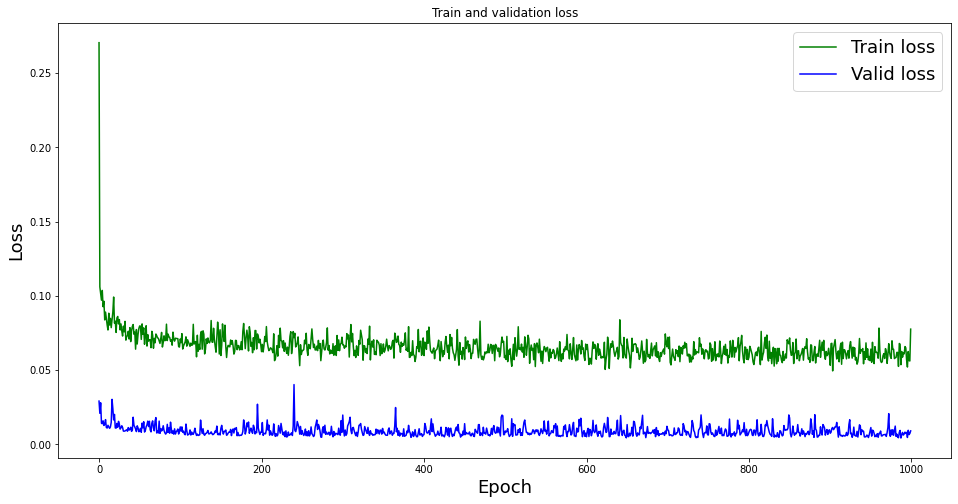

In [ ]:
# Visualize the training
plt.figure(figsize=(16,8))
plt.title('Train and validation loss')
plt.plot(train_loss_array, color = "green", label = "Train loss")
plt.plot(valid_loss_array, color = "blue", label = "Valid loss")
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.legend(fontsize=18)
plt.show()

In [ ]:
#for the test calculate all the point and then inverse it back and
#after that plot it with the real values to compare them
CNN.load_state_dict(torch.load('drive/MyDrive/price_feature_best_model_cnn_1.pt'))

predict_test_array = []

with torch.no_grad():
    for x in test_X:
        CNN.eval()
        predict = CNN(x.reshape(1,-1).to(device))        
        predict_test_array.append(predict.item()*output.std()+output.mean())

real_test_array = []

for y in test_Y:
    real_test_array.append(y*output.std()+output.mean())

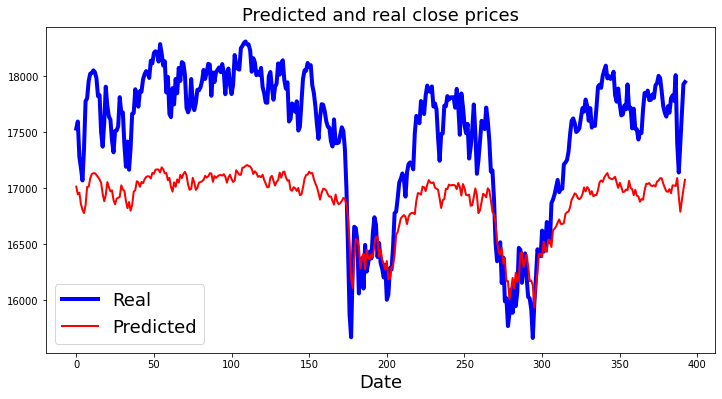

The accuracy of trend predict:	47.58269720101781 %


In [ ]:
#visualize it
f = plt.figure(figsize=(24,12))
plt.title("Predicted and real close prices", fontsize = 18)
plt.plot(real_test_array, color = "blue", linewidth = 4,
         label = "Real")
plt.plot(predict_test_array, color = "red", linewidth = 2,
         label = "Predicted")
plt.xlabel("Date",fontsize = 18)
plt.legend(fontsize = 18)
f.set_size_inches(12,6)
plt.show()

#check the trend -> create an array with the real and with the predicted trend
#if the current value is bigger than before -> 1
#otherwise (same or smaller) -> 0
real_trend_array = []
predicted_trend_array = []

for element in range(len(real_test_array)):
    if element == 1:
        real_trend_array.append(0)
    elif real_test_array[element].values > real_test_array[element - 1].values:
        real_trend_array.append(1)
    else:
        real_trend_array.append(0)        

for element in range(len(predict_test_array)):
    if element == 1:
        predicted_trend_array.append(0)
    elif predict_test_array[element].values > predict_test_array[element - 1].values:
        predicted_trend_array.append(1)
    else:
        predicted_trend_array.append(0) 

#check the number of differences
trend_diff_array = []
for element in range(len(real_trend_array)):
    if real_trend_array[element] != predicted_trend_array[element]:
      trend_diff_array.append(element)

#percentage of predict
print("The accuracy of trend predict:\t" + str((len(real_trend_array)-len(trend_diff_array))/len(real_trend_array)*100) + " %")

In [ ]:
# model re-creation from https://github.com/wonabru/kaggle-two-sigma-winner/blob/master/documentation/Two%20Sigma%20Using%20News%20to%20Predict%20Stock%20Movements%20Kaggle%20Winner%20Call%20-%20v2.pdf
class ANN_from_KAGGLE(nn.Module):

    def __init__(self):
        super(ANN_from_KAGGLE, self).__init__()
        # batch normalization -> may try out without normalized data
        self.norm = nn.BatchNorm1d(12)

        self.linear1 = nn.Linear(12,32) # relu + regularizers?
        self.linear2 = nn.Linear(32,16) # relu + regularizers?
        self.linear3 = nn.Linear(16,8) # relu + regularizers?

        self.out = nn.Linear(8,1)

        self.dropout = nn.Dropout(0.4)


    def forward(self, x):
        x = self.norm(x)

        x = self.dropout(F.relu(self.linear1(x)))
        x = self.dropout(F.relu(self.linear2(x)))  
        x = self.dropout(self.linear3(x)) 

        x = self.out(x)
        return x

# create dataset for classification output
train_Y_class_values = []
for index, row in train.iterrows():
  # going up -> 1; otherwise 0
  if row["Next Close"] > row["Close"]:
    train_Y_class_values.append(1)
  else:
    train_Y_class_values.append(0)

train_Y_class = torch.tensor(train_Y_class_values)  

valid_Y_class_values = []
for index, row in valid.iterrows():
  # going up -> 1; otherwise 0
  if row["Next Close"] > row["Close"]:
    valid_Y_class_values.append(1)
  else:
    valid_Y_class_values.append(0)

valid_Y_class = torch.tensor(valid_Y_class_values) 

test_Y_class_values = []
for index, row in test.iterrows():
  # going up -> 1; otherwise 0
  if row["Next Close"] > row["Close"]:
    test_Y_class_values.append(1)
  else:
    test_Y_class_values.append(0)

test_Y_class = torch.tensor(test_Y_class_values)  

train_tensor_class = data_utils.TensorDataset(train_X, train_Y_class) 
valid_tensor_class = data_utils.TensorDataset(valid_X, valid_Y_class) 
test_tensor_class = data_utils.TensorDataset(test_X, test_Y_class) 

train_loader_class = data_utils.DataLoader(dataset = train_tensor_class, 
                                     batch_size = 128, shuffle = True)
valid_loader_class = data_utils.DataLoader(dataset = valid_tensor_class, 
                                     batch_size = 128, shuffle = True) 

ANN_from_KAGGLE = ANN_from_KAGGLE()
print(ANN_from_KAGGLE)

print(f'The model has {count_parameters(ANN_from_KAGGLE):,} trainable parameters')

optimizer = optim.Adam(ANN_from_KAGGLE.parameters(), lr=0.001)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Show it
print(device)

#custom criterion # this is for classification, sigmoid last layer :) -> i dont understand this
#try it with abs maybe
#def custom_criterion(y_pred, y_true):
#  x = y_true * (2 * y_pred - 1)
#  return 100 - (torch.sum(x) / (torch.std(x) + 0.001))

ANN_from_KAGGLE = ANN_from_KAGGLE.to(device)
criterion = nn.BCEWithLogitsLoss()

# Training with Validation
epochs = 1000
min_valid_loss = np.inf

#store the losses
train_loss_array = []
valid_loss_array = []
  
for e in range(epochs):
    start_time = time.time()

    train_loss = 0.0
    ANN_from_KAGGLE.train()
    for x, y in train_loader_class:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
          
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        pred_y = ANN_from_KAGGLE(x)
        # Find the Loss
        loss = criterion(pred_y.flatten(),y.float())
        # Calculate gradients 
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item() * x.size(0)

    train_loss = train_loss / len(train_loader.sampler)
    train_loss_array.append(train_loss) 

    valid_loss = 0.0
    ANN_from_KAGGLE.eval()     # Optional when not using Model Specific layer
    for x, y in valid_loader_class:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
          
        # Forward Pass
        pred_y = ANN_from_KAGGLE(x)
        # Find the Loss
        loss = criterion(pred_y.flatten(),y.float())
        # Calculate Loss
        valid_loss += loss.item() * x.size(0)
  
    valid_loss = valid_loss / len(valid_loader.sampler)
    valid_loss_array.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch {e+1} \t\t Epoch time: {epoch_mins}m {epoch_secs}s\n\t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')
      
    if min_valid_loss > valid_loss:
        print(f'\t\t Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
          
        # Saving State Dict
        torch.save(ANN_from_KAGGLE.state_dict(), 'drive/MyDrive/price_feature_best_model_kaggle.pt')

    print("")

# Saving State Dict
torch.save(ANN_from_KAGGLE.state_dict(), 'drive/MyDrive/price_feature_last_model_kaggle.pt')    

ANN_from_KAGGLE(
  (norm): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=12, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
The model has 1,113 trainable parameters
cuda
Epoch 1 		 Epoch time: 0m 0s
		 Training Loss: 0.6961295297068935 		 Validation Loss: 0.6916920491150621
		 Validation Loss Decreased(inf--->0.691692) 	 Saving The Model

Epoch 2 		 Epoch time: 0m 0s
		 Training Loss: 0.6916358526574735 		 Validation Loss: 0.691639031617696
		 Validation Loss Decreased(0.691692--->0.691639) 	 Saving The Model

Epoch 3 		 Epoch time: 0m 0s
		 Training Loss: 0.6897507944414693 		 Validation Loss: 0.6912483497127019
		 Validation Loss Decreased(0.691639--->0.691248) 	 Saving The Model

Epoch 4 		 Epoch time: 0m 0s
		

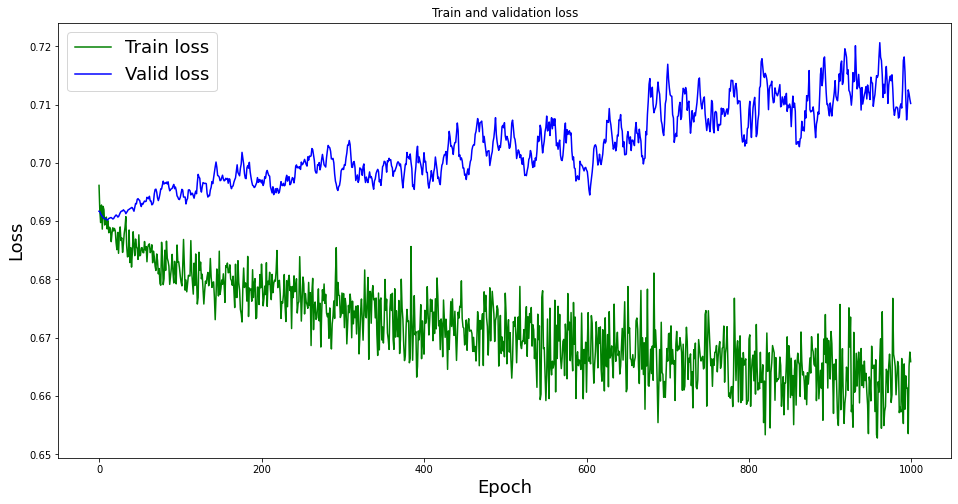

In [ ]:
# Visualize the training
plt.figure(figsize=(16,8))
plt.title('Train and validation loss')
plt.plot(train_loss_array, color = "green", label = "Train loss")
plt.plot(valid_loss_array, color = "blue", label = "Valid loss")
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.legend(fontsize=18)
plt.show()

In [ ]:
#for the test calculate all the point and then inverse it back and
#after that plot it with the real values to compare them
ANN_from_KAGGLE.load_state_dict(torch.load('drive/MyDrive/price_feature_best_model_kaggle.pt'))

predict_test_array = []

with torch.no_grad():
    for x in test_X:
        ANN_from_KAGGLE.eval()

        if torch.cuda.is_available():
          x = x.cuda()

        predict = ANN_from_KAGGLE(x.reshape(1,-1)) 
        predict_test_array.append(round(predict.item()))

real_test_array = test_Y_class_values

#check the trend
trend_diff_array = []
for element in range(len(real_test_array)):
    if real_test_array[element] != predict_test_array[element]:
      trend_diff_array.append(element)      

#percentage of predict
print("The accuracy of trend predict:\t" + str((len(real_test_array)-len(trend_diff_array))/len(real_test_array)*100) + " %")        

The accuracy of trend predict:	49.10941475826972 %


CNN_1(
  (lin1): Linear(in_features=12, out_features=24, bias=True)
  (lin2): Linear(in_features=24, out_features=128, bias=True)
  (lin3): Linear(in_features=128, out_features=64, bias=True)
  (lin4): Linear(in_features=64, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=1, bias=True)
  (dropout): Dropout(p=0.33, inplace=False)
)
The model has 12,561 trainable parameters
Epoch 1 		 Epoch time: 0m 0s
		 Training Loss: 0.3920465828961549 		 Validation Loss: 0.046049556640419945
		 Validation Loss Decreased(inf--->0.046050) 	 Saving The Model

Epoch 2 		 Epoch time: 0m 0s
		 Training Loss: 0.13491557317142372 		 Validation Loss: 0.0419148734602461
		 Validation Loss Decreased(0.046050--->0.041915) 	 Saving The Model

Epoch 3 		 Epoch time: 0m 0s
		 Training Loss: 0.10887607585493292 		 Validation Loss: 0.0228917668395825
		 Validation Loss Decreased(0.041915--->0.022892) 	 Saving The Model

Epoch 4 		 Epoch time: 0m 0s
		 Training Loss: 0.10333063337060105 		 Val

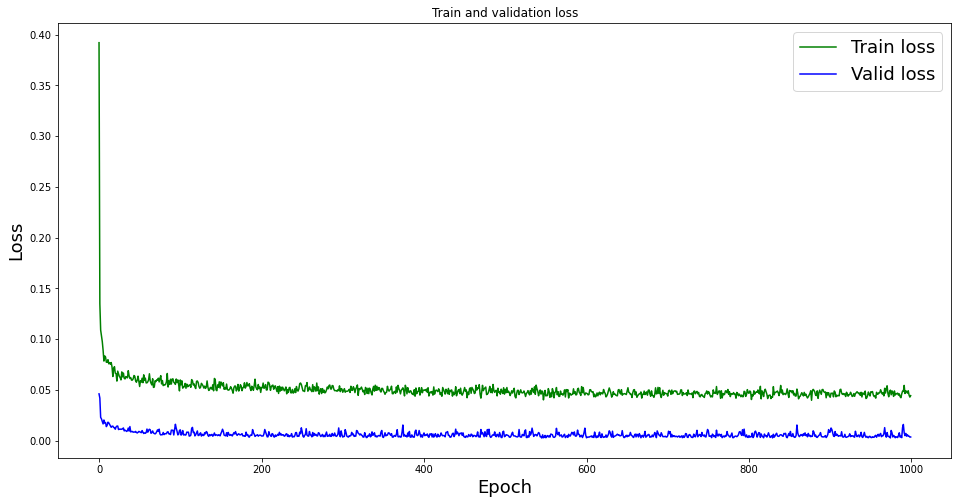

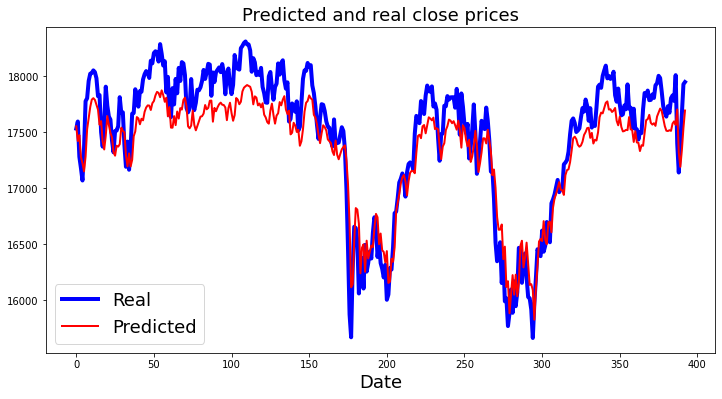

The accuracy of trend predict:	47.07379134860051 %


In [ ]:
CNN = CNN_1(batch_norm = False, dropout = 0.33)
print(CNN)

print(f'The model has {count_parameters(CNN):,} trainable parameters')

optimizer = optim.Adam(CNN.parameters(), lr=0.001)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()

CNN = CNN.to(device)
criterion = criterion.to(device)

# Training with Validation
epochs = 1000
min_valid_loss = np.inf

#store the losses
train_loss_array = []
valid_loss_array = []
  
for e in range(epochs):
    start_time = time.time()

    train_loss = 0.0
    CNN.train()
    for x, y in train_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
          
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        pred_y = CNN(x)
        # Find the Loss
        loss = criterion(pred_y,y)
        # Calculate gradients 
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item() * x.size(0)

    train_loss = train_loss / len(train_loader.sampler)
    train_loss_array.append(train_loss) 

    valid_loss = 0.0
    CNN.eval()     # Optional when not using Model Specific layer
    for x, y in valid_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
          
        # Forward Pass
        pred_y = CNN(x)
        # Find the Loss
        loss = criterion(pred_y,y)
        # Calculate Loss
        valid_loss += loss.item() * x.size(0)
  
    valid_loss = valid_loss / len(valid_loader.sampler)
    valid_loss_array.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch {e+1} \t\t Epoch time: {epoch_mins}m {epoch_secs}s\n\t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')
      
    if min_valid_loss > valid_loss:
        print(f'\t\t Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
          
        # Saving State Dict
        torch.save(CNN.state_dict(), 'drive/MyDrive/price_feature_best_model_cnn_2.pt')

    print("")

# Saving State Dict
torch.save(CNN.state_dict(), 'drive/MyDrive/price_feature_last_model_cnn_2.pt')    

# Visualize the training
plt.figure(figsize=(16,8))
plt.title('Train and validation loss')
plt.plot(train_loss_array, color = "green", label = "Train loss")
plt.plot(valid_loss_array, color = "blue", label = "Valid loss")
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.legend(fontsize=18)
plt.show()

#for the test calculate all the point and then inverse it back and
#after that plot it with the real values to compare them
CNN.load_state_dict(torch.load('drive/MyDrive/price_feature_best_model_cnn_2.pt'))

predict_test_array = []

with torch.no_grad():
    for x in test_X:
        CNN.eval()
        predict = CNN(x.reshape(1,-1).to(device))        
        predict_test_array.append(predict.item()*output.std()+output.mean())

real_test_array = []

for y in test_Y:
    real_test_array.append(y*output.std()+output.mean())

#visualize it
f = plt.figure(figsize=(24,12))
plt.title("Predicted and real close prices", fontsize = 18)
plt.plot(real_test_array, color = "blue", linewidth = 4,
         label = "Real")
plt.plot(predict_test_array, color = "red", linewidth = 2,
         label = "Predicted")
plt.xlabel("Date",fontsize = 18)
plt.legend(fontsize = 18)
f.set_size_inches(12,6)
plt.show()

#check the trend -> create an array with the real and with the predicted trend
#if the current value is bigger than before -> 1
#otherwise (same or smaller) -> 0
real_trend_array = []
predicted_trend_array = []

for element in range(len(real_test_array)):
    if element == 1:
        real_trend_array.append(0)
    elif real_test_array[element].values > real_test_array[element - 1].values:
        real_trend_array.append(1)
    else:
        real_trend_array.append(0)        

for element in range(len(predict_test_array)):
    if element == 1:
        predicted_trend_array.append(0)
    elif predict_test_array[element].values > predict_test_array[element - 1].values:
        predicted_trend_array.append(1)
    else:
        predicted_trend_array.append(0) 

#check the number of differences
trend_diff_array = []
for element in range(len(real_trend_array)):
    if real_trend_array[element] != predicted_trend_array[element]:
      trend_diff_array.append(element)

#percentage of wrong predict
print("The accuracy of trend predict:\t" + str((len(real_trend_array)-len(trend_diff_array))/len(real_trend_array)*100) + " %")

CNN_1(
  (lin1): Linear(in_features=12, out_features=24, bias=True)
  (lin2): Linear(in_features=24, out_features=128, bias=True)
  (lin3): Linear(in_features=128, out_features=64, bias=True)
  (lin4): Linear(in_features=64, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
The model has 12,561 trainable parameters
Epoch 1 		 Epoch time: 0m 0s
		 Training Loss: 0.25947985937265466 		 Validation Loss: 0.08351505847301799
		 Validation Loss Decreased(inf--->0.083515) 	 Saving The Model

Epoch 2 		 Epoch time: 0m 0s
		 Training Loss: 0.03634579640027319 		 Validation Loss: 0.018344171345233917
		 Validation Loss Decreased(0.083515--->0.018344) 	 Saving The Model

Epoch 3 		 Epoch time: 0m 0s
		 Training Loss: 0.015354646926394747 		 Validation Loss: 0.013087108304709879
		 Validation Loss Decreased(0.018344--->0.013087) 	 Saving The Model

Epoch 4 		 Epoch time: 0m 0s
		 Training Loss: 0.011702359413668033 	

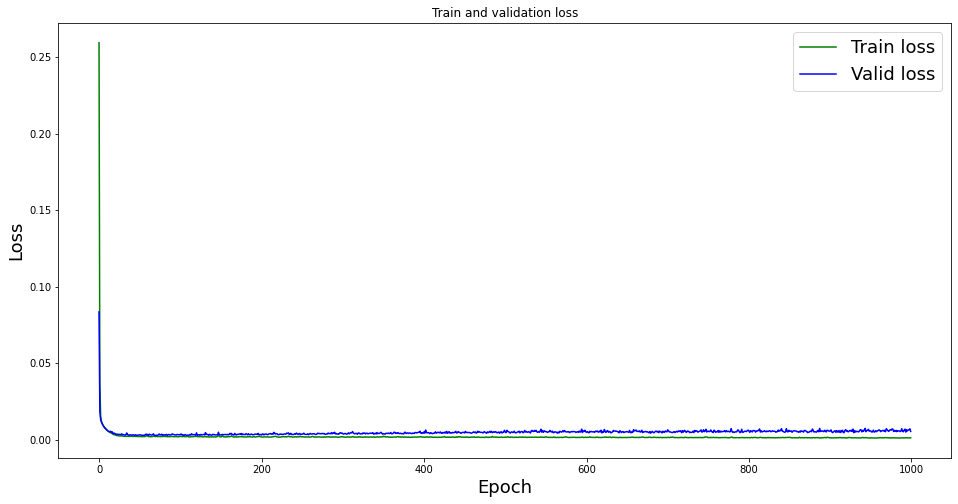

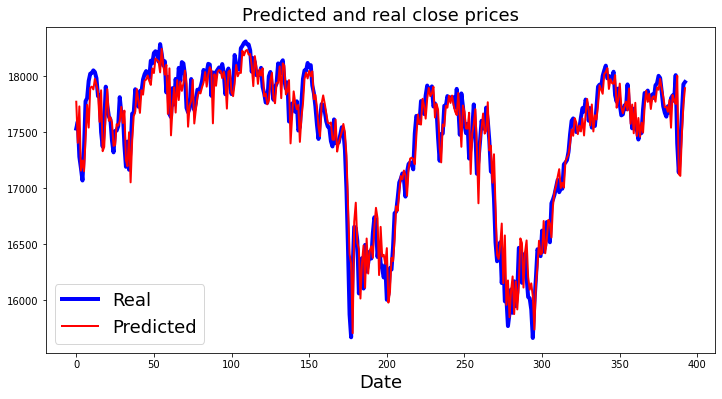

The accuracy of trend predict:	46.31043256997455 %


In [ ]:
CNN = CNN_1(batch_norm = False, dropout = 0.0)
print(CNN)

print(f'The model has {count_parameters(CNN):,} trainable parameters')

optimizer = optim.Adam(CNN.parameters(), lr=0.001)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()

CNN = CNN.to(device)
criterion = criterion.to(device)

# Training with Validation
epochs = 1000
min_valid_loss = np.inf

#store the losses
train_loss_array = []
valid_loss_array = []
  
for e in range(epochs):
    start_time = time.time()

    train_loss = 0.0
    CNN.train()
    for x, y in train_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
          
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        pred_y = CNN(x)
        # Find the Loss
        loss = criterion(pred_y,y)
        # Calculate gradients 
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item() * x.size(0)

    train_loss = train_loss / len(train_loader.sampler)
    train_loss_array.append(train_loss) 

    valid_loss = 0.0
    CNN.eval()     # Optional when not using Model Specific layer
    for x, y in valid_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
          
        # Forward Pass
        pred_y = CNN(x)
        # Find the Loss
        loss = criterion(pred_y,y)
        # Calculate Loss
        valid_loss += loss.item() * x.size(0)
  
    valid_loss = valid_loss / len(valid_loader.sampler)
    valid_loss_array.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch {e+1} \t\t Epoch time: {epoch_mins}m {epoch_secs}s\n\t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')
      
    if min_valid_loss > valid_loss:
        print(f'\t\t Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
          
        # Saving State Dict
        torch.save(CNN.state_dict(), 'drive/MyDrive/price_feature_best_model_cnn_3.pt')

    print("")

# Saving State Dict
torch.save(CNN.state_dict(), 'drive/MyDrive/price_feature_last_model_cnn_3.pt')    

# Visualize the training
plt.figure(figsize=(16,8))
plt.title('Train and validation loss')
plt.plot(train_loss_array, color = "green", label = "Train loss")
plt.plot(valid_loss_array, color = "blue", label = "Valid loss")
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.legend(fontsize=18)
plt.show()

#for the test calculate all the point and then inverse it back and
#after that plot it with the real values to compare them
CNN.load_state_dict(torch.load('drive/MyDrive/price_feature_best_model_cnn_3.pt'))

predict_test_array = []

with torch.no_grad():
    for x in test_X:
        CNN.eval()
        predict = CNN(x.reshape(1,-1).to(device))        
        predict_test_array.append(predict.item()*output.std()+output.mean())

real_test_array = []

for y in test_Y:
    real_test_array.append(y*output.std()+output.mean())

#visualize it
f = plt.figure(figsize=(24,12))
plt.title("Predicted and real close prices", fontsize = 18)
plt.plot(real_test_array, color = "blue", linewidth = 4,
         label = "Real")
plt.plot(predict_test_array, color = "red", linewidth = 2,
         label = "Predicted")
plt.xlabel("Date",fontsize = 18)
plt.legend(fontsize = 18)
f.set_size_inches(12,6)
plt.show()

#check the trend -> create an array with the real and with the predicted trend
#if the current value is bigger than before -> 1
#otherwise (same or smaller) -> 0
real_trend_array = []
predicted_trend_array = []

for element in range(len(real_test_array)):
    if element == 1:
        real_trend_array.append(0)
    elif real_test_array[element].values > real_test_array[element - 1].values:
        real_trend_array.append(1)
    else:
        real_trend_array.append(0)        

for element in range(len(predict_test_array)):
    if element == 1:
        predicted_trend_array.append(0)
    elif predict_test_array[element].values > predict_test_array[element - 1].values:
        predicted_trend_array.append(1)
    else:
        predicted_trend_array.append(0) 

#check the number of differences
trend_diff_array = []
for element in range(len(real_trend_array)):
    if real_trend_array[element] != predicted_trend_array[element]:
      trend_diff_array.append(element)

#percentage of wrong predict
print("The accuracy of trend predict:\t" + str((len(real_trend_array)-len(trend_diff_array))/len(real_trend_array)*100) + " %")

ANN_1(
  (norm): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=12, out_features=24, bias=True)
  (lin2): Linear(in_features=24, out_features=128, bias=True)
  (lin3): Linear(in_features=128, out_features=256, bias=True)
  (lin4): Linear(in_features=256, out_features=1024, bias=True)
  (lin5): Linear(in_features=1024, out_features=4096, bias=True)
  (lin6): Linear(in_features=4096, out_features=16384, bias=True)
  (lin7): Linear(in_features=16384, out_features=4096, bias=True)
  (lin8): Linear(in_features=4096, out_features=1024, bias=True)
  (lin9): Linear(in_features=1024, out_features=256, bias=True)
  (lin10): Linear(in_features=256, out_features=128, bias=True)
  (lin11): Linear(in_features=128, out_features=24, bias=True)
  (lin12): Linear(in_features=24, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=1, bias=True)
)
The model has 143,230,369 trainable parameters
Epoch 1 		 Epoch time: 0m 2s
	

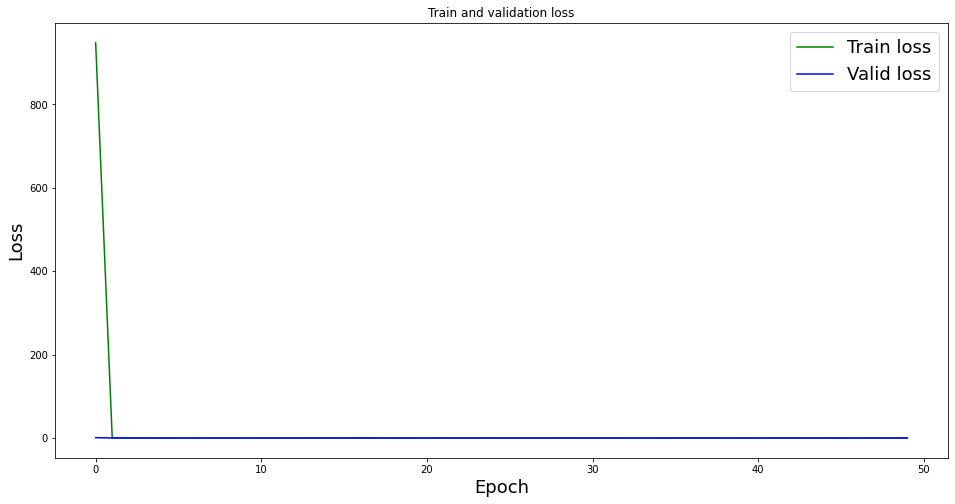

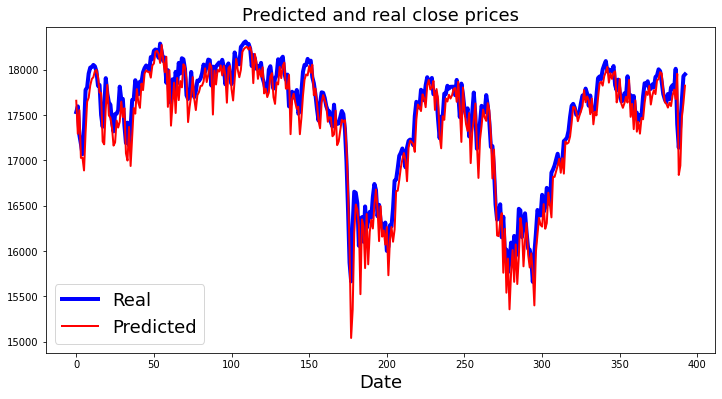

The accuracy of trend predict:	47.58269720101781 %


In [ ]:
class ANN_1(nn.Module):

    def __init__(self):
        super(ANN_1, self).__init__()
        self.norm = nn.BatchNorm1d(12)

        self.lin1 = nn.Linear(12, 24)
        self.lin2 = nn.Linear(24, 128)
        self.lin3 = nn.Linear(128, 256)
        self.lin4 = nn.Linear(256, 1024)
        self.lin5 = nn.Linear(1024, 4096)
        self.lin6 = nn.Linear(4096, 16384)
        self.lin7 = nn.Linear(16384, 4096)
        self.lin8 = nn.Linear(4096, 1024)
        self.lin9 = nn.Linear(1024, 256)
        self.lin10 = nn.Linear(256, 128)
        self.lin11 = nn.Linear(128, 24)
        self.lin12 = nn.Linear(24, 12)
        self.out = nn.Linear(12, 1)
    def forward(self, x):
        x = self.norm(x)

        x = self.lin1(x)
        x = self.lin2(x)
        x = self.lin3(x)
        x = self.lin4(x)
        x = self.lin5(x)
        x = self.lin6(x)
        x = self.lin7(x)
        x = self.lin8(x)   
        x = self.lin9(x)
        x = self.lin10(x)
        x = self.lin11(x)
        x = self.lin12(x)         

        x = self.out(x)

        return x


ANN = ANN_1()
print(ANN)

print(f'The model has {count_parameters(ANN):,} trainable parameters')

optimizer = optim.Adam(ANN.parameters(), lr=0.001)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()

ANN = ANN.to(device)
criterion = criterion.to(device)

# Training with Validation
epochs = 50
min_valid_loss = np.inf

#store the losses
train_loss_array = []
valid_loss_array = []
  
for e in range(epochs):
    start_time = time.time()

    train_loss = 0.0
    ANN.train()
    for x, y in train_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
          
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        pred_y = ANN(x)
        # Find the Loss
        loss = criterion(pred_y,y)
        # Calculate gradients 
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item() * x.size(0)

    train_loss = train_loss / len(train_loader.sampler)
    train_loss_array.append(train_loss) 

    valid_loss = 0.0
    ANN.eval()     # Optional when not using Model Specific layer
    for x, y in valid_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
          
        # Forward Pass
        pred_y = ANN(x)
        # Find the Loss
        loss = criterion(pred_y,y)
        # Calculate Loss
        valid_loss += loss.item() * x.size(0)
  
    valid_loss = valid_loss / len(valid_loader.sampler)
    valid_loss_array.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch {e+1} \t\t Epoch time: {epoch_mins}m {epoch_secs}s\n\t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')
      
    if min_valid_loss > valid_loss:
        print(f'\t\t Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
          
        # Saving State Dict
        torch.save(ANN.state_dict(), 'drive/MyDrive/price_feature_best_model_ann_1.pt')

    print("")

# Saving State Dict
torch.save(ANN.state_dict(), 'drive/MyDrive/price_feature_last_model_ann_1.pt')    

# Visualize the training
plt.figure(figsize=(16,8))
plt.title('Train and validation loss')
plt.plot(train_loss_array, color = "green", label = "Train loss")
plt.plot(valid_loss_array, color = "blue", label = "Valid loss")
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.legend(fontsize=18)
plt.show()

#for the test calculate all the point and then inverse it back and
#after that plot it with the real values to compare them
ANN.load_state_dict(torch.load('drive/MyDrive/price_feature_best_model_ann_1.pt'))

predict_test_array = []

with torch.no_grad():
    for x in test_X:
        ANN.eval()
        predict = ANN(x.reshape(1,-1).to(device))        
        predict_test_array.append(predict.item()*output.std()+output.mean())

real_test_array = []

for y in test_Y:
    real_test_array.append(y*output.std()+output.mean())

#visualize it
f = plt.figure(figsize=(24,12))
plt.title("Predicted and real close prices", fontsize = 18)
plt.plot(real_test_array, color = "blue", linewidth = 4,
         label = "Real")
plt.plot(predict_test_array, color = "red", linewidth = 2,
         label = "Predicted")
plt.xlabel("Date",fontsize = 18)
plt.legend(fontsize = 18)
f.set_size_inches(12,6)
plt.show()

#check the trend -> create an array with the real and with the predicted trend
#if the current value is bigger than before -> 1
#otherwise (same or smaller) -> 0
real_trend_array = []
predicted_trend_array = []

for element in range(len(real_test_array)):
    if element == 1:
        real_trend_array.append(0)
    elif real_test_array[element].values > real_test_array[element - 1].values:
        real_trend_array.append(1)
    else:
        real_trend_array.append(0)        

for element in range(len(predict_test_array)):
    if element == 1:
        predicted_trend_array.append(0)
    elif predict_test_array[element].values > predict_test_array[element - 1].values:
        predicted_trend_array.append(1)
    else:
        predicted_trend_array.append(0) 

#check the number of differences
trend_diff_array = []
for element in range(len(real_trend_array)):
    if real_trend_array[element] != predicted_trend_array[element]:
      trend_diff_array.append(element)

#percentage of wrong predict
print("The accuracy of trend predict:\t" + str((len(real_trend_array)-len(trend_diff_array))/len(real_trend_array)*100) + " %")

In [ ]:
torch.cat([train_tensor.tensors[0], valid_tensor.tensors[0]],0).shape

torch.Size([1571, 12])

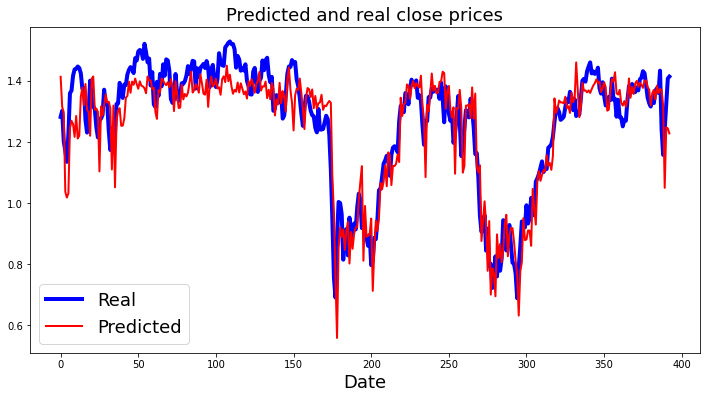

The accuracy of trend predict:	48.091603053435115 %


In [ ]:
# set batch size
# change back
train_loader = data_utils.DataLoader(dataset = train_tensor, 
                                     batch_size = 64, shuffle = True)
valid_loader = data_utils.DataLoader(dataset = valid_tensor, 
                                     batch_size = 64, shuffle = True)

# create XGBOOST
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import sklearn
clf = XGBRegressor(objective='reg:squarederror', max_depth=5, learning_rate=1,
                   n_estimators=1000)

clf.fit(torch.cat([train_tensor.tensors[0], valid_tensor.tensors[0]],0),
        torch.cat([train_tensor.tensors[1], valid_tensor.tensors[1]],0),)

prediction = clf.predict(test_tensor.tensors[0])

score = sklearn.metrics.mean_squared_error(test_tensor.tensors[1],
                                           prediction)

score

#visualize it
f = plt.figure(figsize=(24,12))
plt.title("Predicted and real close prices", fontsize = 18)
plt.plot(test_tensor.tensors[1], color = "blue", linewidth = 4,
         label = "Real")
plt.plot(prediction, color = "red", linewidth = 2,
         label = "Predicted")
plt.xlabel("Date",fontsize = 18)
plt.legend(fontsize = 18)
f.set_size_inches(12,6)
plt.show()

#check the trend -> create an array with the real and with the predicted trend
#if the current value is bigger than before -> 1
#otherwise (same or smaller) -> 0
real_trend_array = []
predicted_trend_array = []

for element in range(len(test_tensor.tensors[1])):
    if element == 1:
        real_trend_array.append(0)
    elif test_tensor.tensors[1][element].item() > test_tensor.tensors[1][element - 1].item():
        real_trend_array.append(1)
    else:
        real_trend_array.append(0)        

for element in range(len(prediction)):
    if element == 1:
        predicted_trend_array.append(0)
    elif prediction[element].item() > prediction[element - 1].item():
        predicted_trend_array.append(1)
    else:
        predicted_trend_array.append(0) 

#check the number of differences
trend_diff_array = []
for element in range(len(real_trend_array)):
    if real_trend_array[element] != predicted_trend_array[element]:
      trend_diff_array.append(element)

#percentage of wrong predict
print("The accuracy of trend predict:\t" + str((len(real_trend_array)-len(trend_diff_array))/len(real_trend_array)*100) + " %")

# Common functions for automat

In [6]:
def calc_score(prediction,real):
  prediction = torch.FloatTensor(prediction)
  real = torch.FloatTensor(real)
  score = 0
  loss = criterion(prediction,real)
  score = loss.item()
  score = score / len(prediction)
  return score   

In [7]:
def set_reproduce(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  np.random.seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  random.seed(seed)

set_reproduce(seed=1)

In [8]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Automat test linear

In [ ]:
# function for starting parameter tuning
def run_model(bath_size_in, model_in, optimizer_in, criterion_in, gen_num_in):
  print(f'Start of the {gen_num_in}\n')
  # check if needed padding:
  if len(train_X_std) % bath_size_in == 0:
    train_tensor_gen = data_utils.TensorDataset(train_X_std, train_Y_std)
  else:
    res = int(len(train_X_std) / bath_size_in)
    needed_length = (res + 1) * bath_size_in
    pad = nn.ConstantPad2d((0,0,0,needed_length-len(train_X_std)),0)
    padded_train_X = pad(train_X_std)
    padded_train_Y = pad(train_Y_std)
    train_tensor_gen = data_utils.TensorDataset(padded_train_X, padded_train_Y)

  if len(valid_X_std) % bath_size_in == 0:
    valid_tensor_gen = data_utils.TensorDataset(valid_X_std, valid_Y_std)
  else:
    res = int(len(valid_X_std) / bath_size_in)
    needed_length = (res + 1) * bath_size_in
    pad = nn.ConstantPad2d((0,0,0,needed_length-len(valid_X_std)),0)
    padded_valid_X = pad(valid_X_std)
    padded_valid_Y = pad(valid_Y_std)
    valid_tensor_gen = data_utils.TensorDataset(padded_valid_X, padded_valid_Y)    

  train_loader_gen = data_utils.DataLoader(dataset = train_tensor_gen, 
                                       batch_size = bath_size_in, shuffle = True)
  valid_loader_gen = data_utils.DataLoader(dataset = valid_tensor_gen, 
                                      batch_size = bath_size_in, shuffle = True)                                   
  
  model = model_in

  optimizer = optimizer_in

  # Set the device
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  criterion = criterion_in

  model = model.to(device)
  criterion = criterion.to(device)

  # Training with Validation
  min_valid_loss = np.inf
  epoch_num = 500

  #store the losses
  train_loss_array = []
  valid_loss_array = []
  epoch = 0

  real_test_array = []
  real_trend_array = []  
  for y in test_Y:
    real_test_array.append(y*output_df.std()+output_df.mean())   
  for element in range(len(real_test_array)):
    if element == 1:
        real_trend_array.append(0)
    elif real_test_array[element].values > real_test_array[element - 1].values:
        real_trend_array.append(1)
    else:
        real_trend_array.append(0)      

  early_stop = False
  exploded = False
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', cooldown=5, patience=15, factor=0.75)
  for e in range(epoch_num):
      start_time = time.time()

      train_loss = 0.0
      model.train()
      for x, y in train_loader_gen:
          # Transfer Data to GPU if available
          if torch.cuda.is_available():
              x, y = x.cuda(), y.cuda()
            
          # Clear the gradients
          optimizer.zero_grad()
          # Forward Pass
          pred_y = model(x)
          # Find the Loss
          loss = criterion(pred_y,y)
          # Calculate gradients 
          loss.backward()
          # Update Weights
          optimizer.step()
          # Calculate Loss
          train_loss += loss.item() * x.size(0)

      train_loss = train_loss / len(train_loader.sampler)
      train_loss_array.append(train_loss) 

      valid_loss = 0.0
      model.eval()     # Optional when not using Model Specific layer
      for x, y in valid_loader_gen:
          # Transfer Data to GPU if available
          if torch.cuda.is_available():
              x, y = x.cuda(), y.cuda()
            
          # Forward Pass
          pred_y = model(x)
          # Find the Loss
          loss = criterion(pred_y,y)
          # Calculate Loss
          valid_loss += loss.item() * x.size(0)
    
      valid_loss = valid_loss / len(valid_loader.sampler)
      scheduler.step(valid_loss) # dynamic learning rate scheduler
      valid_loss_array.append(valid_loss)

      end_time = time.time()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      
      if e in [99,199,299,399,499]:
        print(f'Epoch {e+1} \t\t Epoch time: {epoch_mins}m {epoch_secs}s\n\t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')
        if train_loss > 100:
          print("Exploded")
          exploded = True
          torch.save(model.state_dict(), 'drive/MyDrive/automat/model/price_feature_best_model_gen_' + str(gen_num_in) + '.pt')
          epoch = e
          break
        
      if min_valid_loss > valid_loss:            
          # Saving State Dict
          torch.save(model.state_dict(), 'drive/MyDrive/automat/model/price_feature_best_model_gen_' + str(gen_num_in) + '.pt')
          epoch = e

          # early stop
          if (valid_loss < 0.05 or train_loss < 0.05) or (min_valid_loss - valid_loss) < 0.0005:
              early_stop = True
              min_valid_loss = valid_loss
        
      if  early_stop == True and e > 50:
          print(f'\tEarly stop of the training')
          break 

  # Visualize the training
  f1 = plt.figure(figsize=(16,8))
  plt.title('Train and validation loss')
  plt.plot(train_loss_array, color = "green", label = "Train loss")
  plt.plot(valid_loss_array, color = "blue", label = "Valid loss")
  plt.xlabel('Epoch',fontsize=18)
  plt.ylabel('Loss',fontsize=18)
  plt.legend(fontsize=18)
  teach_plt = f1
  plt.close()

  #print("Index num:\t" + str(i))
  model.load_state_dict(torch.load('drive/MyDrive/automat/model/price_feature_best_model_gen_' + str(gen_num_in) + '.pt'))

  predict_test_array = []

  with torch.no_grad():
      for x in test_X:
          model.eval()
          predict = model(x.reshape(1,-1).to(device))        
          predict_test_array.append(predict.item()*output_df.std()+output_df.mean()) 

  # calculate score
  score = calc_score(predict_test_array,real_test_array)    
  print(f"\nScore: {score}\n")      

  #check the trend -> create an array with the real and with the predicted trend
  #if the current value is bigger than before -> 1
  #otherwise (same or smaller) -> 0
  predicted_trend_array = []  

  for element in range(len(predict_test_array)):
      if element == 1:
          predicted_trend_array.append(0)
      elif predict_test_array[element].values > predict_test_array[element - 1].values:
          predicted_trend_array.append(1)
      else:
          predicted_trend_array.append(0) 

  #check the number of differences
  trend_diff_array = []
  for element in range(len(real_trend_array)):
      if real_trend_array[element] != predicted_trend_array[element]:
        trend_diff_array.append(element)

  #percentage of good predict
  acc = (len(real_trend_array)-len(trend_diff_array))/len(real_trend_array)*100

  #visualize it
  f2 = plt.figure(figsize=(24,12))
  plt.title("Predicted and real close prices", fontsize = 18)
  plt.plot(real_test_array, color = "blue", linewidth = 4,
          label = "Real")
  plt.plot(predict_test_array, color = "red", linewidth = 2,
          label = "Predicted")
  plt.xlabel("Date",fontsize = 18)
  plt.legend(fontsize = 18)
  f2.set_size_inches(12,6)
  plt_best = f2
  plt.close()

  # return the results for compare:
  #   gen_num
  #   epoch
  #   trend result (best)
  #   diagram (best)
  #   exploded
  #   score
  return gen_num_in, epoch, acc, teach_plt, plt_best, exploded, score

In [ ]:
# define the model architects for the test
# simple linears
class Linear_generic(nn.Module):
    def __init__(self, layer_deepness, dropout_in, act_type): # 
        super(Linear_generic, self).__init__()

        self.fc = nn.ModuleList()
        if layer_deepness == 3:
          self.layer_deepness = 3
          self.fc.append(nn.Linear(12, 64))
          self.fc.append(nn.Linear(64, 16))
          self.fc.append(nn.Linear(16, 1))
        elif layer_deepness == 4:
          self.layer_deepness = 5
          self.fc.append(nn.Linear(12, 64))
          self.fc.append(nn.Linear(64, 128))
          self.fc.append(nn.Linear(128, 64))
          self.fc.append(nn.Linear(64, 16))
          self.fc.append(nn.Linear(16, 1))
        elif layer_deepness == 5:
          self.layer_deepness = 7
          self.fc.append(nn.Linear(12, 64))
          self.fc.append(nn.Linear(64, 128))
          self.fc.append(nn.Linear(128, 256))
          self.fc.append(nn.Linear(256, 128))
          self.fc.append(nn.Linear(128, 64))
          self.fc.append(nn.Linear(64, 16))
          self.fc.append(nn.Linear(16, 1))
        elif layer_deepness == 6:
          self.layer_deepness = 9
          self.fc.append(nn.Linear(12, 64))
          self.fc.append(nn.Linear(64, 128))
          self.fc.append(nn.Linear(128, 256))
          self.fc.append(nn.Linear(256, 512))
          self.fc.append(nn.Linear(512, 256))
          self.fc.append(nn.Linear(256, 128))
          self.fc.append(nn.Linear(128, 64))
          self.fc.append(nn.Linear(64, 16))
          self.fc.append(nn.Linear(16, 1))
        elif layer_deepness == 7:
          self.layer_deepness = 11
          self.fc.append(nn.Linear(12, 64))
          self.fc.append(nn.Linear(64, 128))
          self.fc.append(nn.Linear(128, 256))
          self.fc.append(nn.Linear(256, 512))
          self.fc.append(nn.Linear(512, 1024))  
          self.fc.append(nn.Linear(1024, 512))               
          self.fc.append(nn.Linear(512, 256))
          self.fc.append(nn.Linear(256, 128))
          self.fc.append(nn.Linear(128, 64))
          self.fc.append(nn.Linear(64, 16))
          self.fc.append(nn.Linear(16, 1))
        elif layer_deepness == 8:
          self.layer_deepness = 13
          self.fc.append(nn.Linear(12, 64))
          self.fc.append(nn.Linear(64, 128))
          self.fc.append(nn.Linear(128, 256))
          self.fc.append(nn.Linear(256, 512))
          self.fc.append(nn.Linear(512, 1024))  
          self.fc.append(nn.Linear(1024, 2048)) 
          self.fc.append(nn.Linear(2048, 1024)) 
          self.fc.append(nn.Linear(1024, 512))               
          self.fc.append(nn.Linear(512, 256))
          self.fc.append(nn.Linear(256, 128))
          self.fc.append(nn.Linear(128, 64))
          self.fc.append(nn.Linear(64, 16))
          self.fc.append(nn.Linear(16, 1))
        else:
            raise ValueError("Not valid layer deepness")    

        self.dropout = nn.Dropout(dropout_in)
        self.act_type = act_type
        if act_type == 0:
          pass
        elif self.act_type == 1: # tanh
          self.activition = nn.Tanh()
        elif act_type == 2: # sigmoid
          self.activition = nn.Sigmoid()          
        elif act_type == 3: # relu
          self.activition = nn.ReLU()            
        else:
          raise ValueError("No valid activition type")   

    def forward(self, x):
        i = 1
        for fc in self.fc:
          if self.act_type == 0: # no act
            if i == self.layer_deepness:
              x = fc(x)
            else:
              x = self.dropout(fc(x))
          else: # act
            if i == self.layer_deepness:
              x = fc(x)
            else:
              x = self.dropout(self.activition(fc(x)))
          i += 1

        return x

In [ ]:
# todo: # to use need to write to load the csv as dataframe and get the results for it
def show_all_res(): 
  best_score = np.inf
  best_score_index = np.inf
  for i in range(len(score_res)):
    if score_res[i] < best_score:
      best_score = score_res[i]
      best_score_index = i

  print(f'The best model is {best_score_index}_{e_res[best_score_index]}:')
  print(f'\t The score of the best model is {best_score} %')
  print(f'\t The accuraccy of the best model is {acc_res[best_score_index]} %')

  print('\n-----------------------------------------------------------------------\n')   

  print('The best models')
  for i in range(len(score_res)):
    print(f'Start of the {i}, and epoch is {e_res[i]}')
    print(f'\t The score of best model is {score_res[i]} %') 
    print(f'\t The accuraccy for trend is: {acc_res[i]} %')

  return best_acc_index    

In [ ]:
batch_size_array = [32,64,128]
layer_d_array = []
for i in range(6):
  layer_d_array.append(i+3)
layer_d_array
dropout_array = []                   
for i in range(5):
  dropout_array.append(i*0.1)
dropout_array
act_type_array = [0,1,2,3]
learning_rate_array = [0.001,0.0001]

gen_num = 0
criterion = nn.MSELoss()

optimizer_array = []
model_array = []
gen_num_res = []
e_res = []
acc_res = []
plt_teach_res = []
plt_pred_res = []
batch_s_res = []
layer_dep_res = []
act_res = []
dropout_res = []
optimizer_start_res = []
optimizer_end_res = []
exploded_res = []
score_res = []

In [ ]:
def save_out_arrays():
  with open("/content/drive/MyDrive/automat/arrays/gen_num_res.txt", "wb") as f:
    pickle.dump(gen_num_res, f)
  with open("/content/drive/MyDrive/automat/arrays/e_res.txt", "wb") as f:
    pickle.dump(e_res, f)
  with open("/content/drive/MyDrive/automat/arrays/acc_res.txt", "wb") as f:
    pickle.dump(acc_res, f)
  with open("/content/drive/MyDrive/automat/arrays/plt_teach_res.txt", "wb") as f:
    pickle.dump(plt_teach_res, f)
  with open("/content/drive/MyDrive/automat/arrays/plt_pred_res.txt", "wb") as f:
    pickle.dump(plt_pred_res, f)    
  with open("/content/drive/MyDrive/automat/arrays/batch_s_res.txt", "wb") as f:
    pickle.dump(batch_s_res, f)
  with open("/content/drive/MyDrive/automat/arrays/layer_dep_res.txt", "wb") as f:
    pickle.dump(layer_dep_res, f)
  with open("/content/drive/MyDrive/automat/arrays/act_res.txt", "wb") as f:
    pickle.dump(act_res, f)
  with open("/content/drive/MyDrive/automat/arrays/droput_res.txt", "wb") as f:
    pickle.dump(dropout_res, f)     
  with open("/content/drive/MyDrive/automat/arrays/optimizer_start_res.txt", "wb") as f:
    pickle.dump(optimizer_start_res, f) 
  with open("/content/drive/MyDrive/automat/arrays/optimizer_end_res.txt", "wb") as f:
    pickle.dump(optimizer_end_res, f)     
  with open("/content/drive/MyDrive/automat/arrays/exploded_res.txt", "wb") as f:
    pickle.dump(exploded_res, f)        
  with open("/content/drive/MyDrive/automat/arrays/score_res.txt", "wb") as f:
    pickle.dump(score_res, f)   

In [ ]:
def load_arrays():
  with open("/content/drive/MyDrive/automat/arrays/gen_num_res.txt", "rb") as f:
    gen_num_res = []
    gen_num_res = pickle.load(f)
  with open("/content/drive/MyDrive/automat/arrays/e_res.txt", "rb") as f:
    e_res = []
    e_res = pickle.load(f)
  with open("/content/drive/MyDrive/automat/arrays/acc_res.txt", "rb") as f:
    acc_res = []
    acc_res = pickle.load(f)
  with open("/content/drive/MyDrive/automat/arrays/plt_teach_res.txt", "rb") as f:
    plt_teach_res = []
    plt_teach_res = pickle.load(f)
  with open("/content/drive/MyDrive/automat/arrays/plt_pred_res.txt", "rb") as f:
    plt_pred_res = []
    plt_pred_res = pickle.load(f)
  with open("/content/drive/MyDrive/automat/arrays/layer_dep_res.txt", "rb") as f:
    layer_dep_res = []
    layer_dep_res = pickle.load(f)
  with open("/content/drive/MyDrive/automat/arrays/act_res.txt", "rb") as f:
    act_res = []
    act_res = pickle.load(f)
  with open("/content/drive/MyDrive/automat/arrays/droput_res.txt", "rb") as f:
    dropout_res = []
    dropout_res = pickle.load(f)
  with open("/content/drive/MyDrive/automat/arrays/optimizer_start_res.txt", "rb") as f:
    optimizer_start_res = []
    optimizer_start_res = pickle.load(f)
  with open("/content/drive/MyDrive/automat/arrays/optimizer_end_res.txt", "rb") as f:
    optimizer_end_res = []
    optimizer_end_res = pickle.load(f)    
  with open("/content/drive/MyDrive/automat/arrays/exploded_res.txt", "rb") as f:  
    exploded_res = []
    exploded_res = pickle.load(f)
  with open("/content/drive/MyDrive/automat/arrays/score_res.txt", "rb") as f:
    score_res = []    
    score_res = pickle.load(f)

In [ ]:
def save_the_log():
  # save the log
  with open("/content/drive/MyDrive/automat/automat_linear_log.csv", "w") as f:
    s = ""      
    s += 'Model;Epoch;Accuraccy;Batch size;LR start;LR end;Dropout;Layer deepness;Activition function;Exploded;Score\n'
    for i in range(len(gen_num_res)):
      s += f'{gen_num_res[i]};{e_res[i]};{acc_res[i]}%;{batch_s_res[i]};{optimizer_start_res[i]};{optimizer_end_res[i]};{dropout_res[i]};{layer_dep_res[i]};{act_res[i]};{exploded_res[i]};{score_res[i]}\n'
    
    f.write(s)

  plt_teach_res[-1].savefig('/content/drive/MyDrive/automat/automat_log_teach_' + str(gen_num_res[-1]) + "_" + str(e_res[-1]) + '.png')
  plt_pred_res[-1].savefig('/content/drive/MyDrive/automat/automat_log_pred_' + str(gen_num_res[-1]) + "_" + str(e_res[-1]) + '.png')      

In [ ]:
params_array = []
for dropout in dropout_array:
  for layer_d in layer_d_array:              
    for learning_rate in learning_rate_array:
      for act_type in act_type_array:
        for batch_s in batch_size_array:
          params = {}
          params['dropout'] = dropout
          params['layer_d'] = layer_d
          params['learning_rate'] = learning_rate
          params['act_type'] = act_type
          params['batch_s'] = batch_s
          params_array.append(params)

#gen_num = 0 # for continue

for i in range(len(params_array)): # every possible, can continue based on index :)
  model = Linear_generic(layer_deepness=params_array[i]['layer_d'],dropout_in=params_array[i]['dropout'],act_type=params_array[i]['act_type'])
  optimizer_array.append(optim.Adam(model.parameters(), params_array[i]['learning_rate']))
  gen_num_out, e_out, acc_out, plt_teach_out, plt_pred_out, exploded_out, score_out = run_model(params_array[i]['batch_s'], model, optimizer_array[i], criterion, gen_num)
  gen_num += 1
  gen_num_res.append(gen_num_out)
  e_res.append(e_out)
  acc_res.append(acc_out)
  plt_teach_res.append(plt_teach_out)
  plt_pred_res.append(plt_pred_out)
  batch_s_res.append(params_array[i]['batch_s'])
  layer_dep_res.append(params_array[i]['layer_d'])
  act_res.append(params_array[i]['act_type'])
  dropout_res.append(params_array[i]['dropout'])
  optimizer_start_res.append(params_array[i]['learning_rate'])
  optimizer_end_res.append(get_lr(optimizer_array[i]))
  exploded_res.append(exploded_out)
  score_res.append(score_out)

  save_out_arrays()
  save_the_log()  

In [ ]:
# normalize dataset
# norm the input and output
input_norm = (input_df - input_df.min()) / (input_df.max() - input_df.min())
output_norm = (output_df - output_df.min()) / (output_df.max() - output_df.min())

# drop the input last row
input_norm.drop(input_norm.tail(1).index,inplace=True)
# drop the output first row
output_norm.drop(output_norm.head(1).index,inplace=True)

data = input_norm
data["Next Close"] = output_norm["Next Close"].values

#shuffle only the train-valid data
np.random.seed(42)
#split to 80% train+valid and 20% test
train_valid, test = np.split(data, [int(.8*len(data))])

#shuffle and split 60% 20% the train and valid
#80% is train+valid -> 75% of train+valid is 60% train from the complete
train, valid = np.split(train_valid.sample(frac=1,random_state=42),
                        [int(0.75*len(train_valid))])

train_Y_norm = torch.tensor(train["Next Close"].values.astype(np.float32))
train_Y_norm = train_Y_norm.view(-1,1)
train_X_norm = torch.tensor(train.drop("Next Close",axis=1).values.astype(np.float32))

valid_Y_norm = torch.tensor(valid["Next Close"].values.astype(np.float32))
valid_Y_norm = valid_Y_norm.view(-1,1)
valid_X_norm = torch.tensor(valid.drop("Next Close",axis=1).values.astype(np.float32))

test_Y_norm = torch.tensor(test["Next Close"].values.astype(np.float32))
test_Y_norm = test_Y_norm.view(-1,1)
test_X_norm = torch.tensor(test.drop("Next Close",axis=1).values.astype(np.float32))

train_tensor_norm = data_utils.TensorDataset(train_X_norm, train_Y_norm) 
valid_tensor_norm = data_utils.TensorDataset(valid_X_norm, valid_Y_norm) 
test_tensor_norm = data_utils.TensorDataset(test_X_norm, test_Y_norm) 

train_loader_norm = data_utils.DataLoader(dataset = train_tensor_norm, 
                                     batch_size = 64, shuffle = True)
valid_loader_norm = data_utils.DataLoader(dataset = valid_tensor_norm, 
                                     batch_size = 64, shuffle = True)

Standardized
Score: 70.62805144720102
Accuracy: 47.58269720101781

Normalized

	Early stop of the training
Score: 60550.834605597964
Accuracy: 46.81933842239186



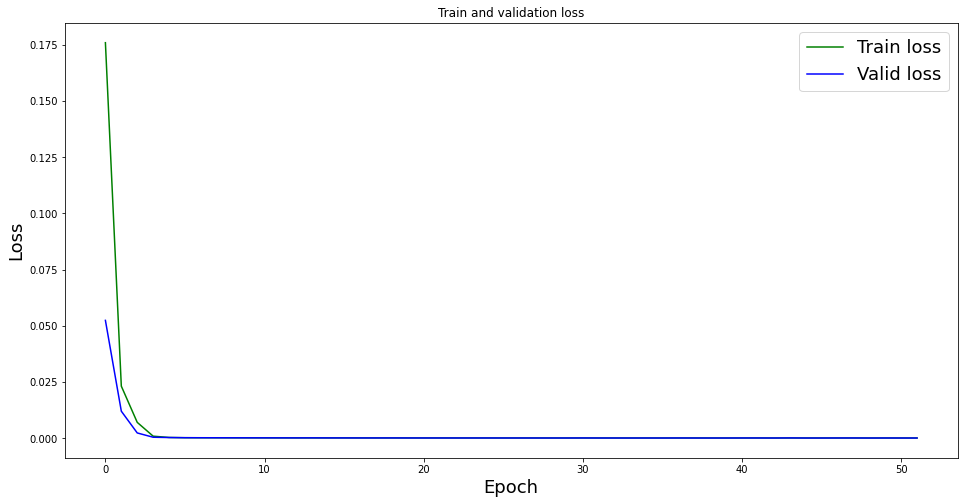

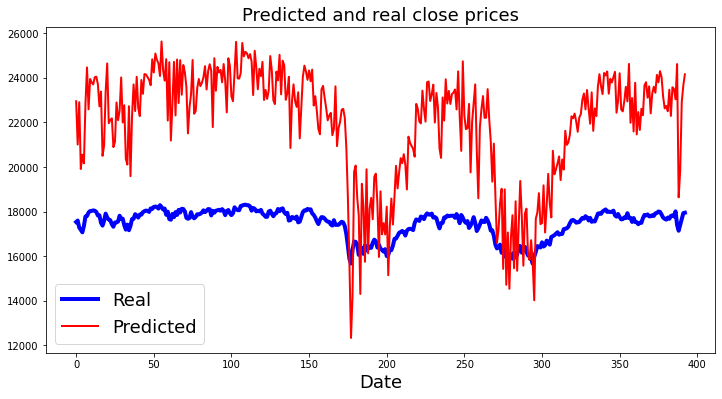

In [ ]:
# check results (stand again vs new norm) -> choose which one to try out LSTM and compare with it
# model 108 !!! -> should be: acc 47.58%, score 70.63, batch 32, lr 0.0001, d 0, layer 11, act none
# check part
# create model 108
model_test = Linear_generic(layer_deepness=7,dropout_in=0,act_type=0)
optim_test = optim.Adam(model_test.parameters(), 0.0001)

model_test.load_state_dict(torch.load('drive/MyDrive/automat/model/price_feature_best_model_gen_' + str(108) + '.pt'))

real_test_array = []
real_trend_array = [] 
for y in test_Y_std:
  real_test_array.append(y*output_df.std()+output_df.mean())   
for element in range(len(real_test_array)):
  if element == 1:
      real_trend_array.append(0)
  elif real_test_array[element].values > real_test_array[element - 1].values:
      real_trend_array.append(1)
  else:
      real_trend_array.append(0)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_test = model_test.to(device)
predict_test_array_std = []
with torch.no_grad():
      for x in test_X_std:
          model_test.eval()
          predict = model_test(x.reshape(1,-1).to(device))        
          predict_test_array_std.append(predict.item()*output_df.std()+output_df.mean()) 

predicted_trend_array_std = []  
for element in range(len(predict_test_array_std)):
    if element == 1:
        predicted_trend_array_std.append(0)
    elif predict_test_array_std[element].values > predict_test_array_std[element - 1].values:
        predicted_trend_array_std.append(1)
    else:
        predicted_trend_array_std.append(0)  

#check the number of differences
trend_diff_array = []
for element in range(len(real_trend_array)):
    if real_trend_array[element] != predicted_trend_array_std[element]:
      trend_diff_array.append(element)                

score_test_std = calc_score(predict_test_array_std,real_test_array)
acc_test_std = (len(real_trend_array)-len(trend_diff_array))/len(real_trend_array)*100

print(f'Standardized\nScore: {score_test_std}')
print(f'Accuracy: {acc_test_std}\n')

###########################################################
# check with normalized
###########################################################
print('Normalized\n')
model_test_norm = Linear_generic(layer_deepness=7,dropout_in=0,act_type=0)
optim_test = optim.Adam(model_test_norm.parameters(), 0.0001)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_test_norm = model_test_norm.to(device)
criterion = nn.MSELoss().to(device)

# Training with Validation
min_valid_loss = np.inf
epoch_num = 500

#store the losses
train_loss_array = []
valid_loss_array = []
epoch = 0    

early_stop = False
exploded = False
scheduler_test = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_test, 'min', cooldown=5, patience=15, factor=0.75)
for e in range(epoch_num):
    start_time = time.time()

    train_loss = 0.0
    model_test_norm.train()
    for x, y in train_loader_norm:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
          
        # Clear the gradients
        optim_test.zero_grad()
        # Forward Pass
        pred_y = model_test_norm(x)
        # Find the Loss
        loss = criterion(pred_y,y)
        # Calculate gradients 
        loss.backward()
        # Update Weights
        optim_test.step()
        # Calculate Loss
        train_loss += loss.item() * x.size(0)

    train_loss = train_loss / len(train_loader.sampler)
    train_loss_array.append(train_loss) 

    valid_loss = 0.0
    model_test_norm.eval()     # Optional when not using Model Specific layer
    for x, y in valid_loader_norm:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
          
        # Forward Pass
        pred_y = model_test_norm(x)
        # Find the Loss
        loss = criterion(pred_y,y)
        # Calculate Loss
        valid_loss += loss.item() * x.size(0)
  
    valid_loss = valid_loss / len(valid_loader.sampler)
    scheduler_test.step(valid_loss) # dynamic learning rate scheduler
    valid_loss_array.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if e in [99,199,299,399,499]:
      print(f'Epoch {e+1} \t\t Epoch time: {epoch_mins}m {epoch_secs}s\n\t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')
      if train_loss > 100:
        print("Exploded")
        exploded = True
        torch.save(model_test_norm.state_dict(), 'drive/MyDrive/automat/model/price_feature_best_model_norm_' + str(108) + '.pt')
        epoch = e
        break
      
    if min_valid_loss > valid_loss:            
        # Saving State Dict
        torch.save(model_test_norm.state_dict(), 'drive/MyDrive/automat/model/price_feature_best_model_norm_' + str(108) + '.pt')
        epoch = e

        # early stop
        if (valid_loss < 0.05 or train_loss < 0.05) or (min_valid_loss - valid_loss) < 0.0005:
            early_stop = True
            min_valid_loss = valid_loss
      
    if  early_stop == True and e > 50:
        print(f'\tEarly stop of the training')
        break 

# Visualize the training
f1 = plt.figure(figsize=(16,8))
plt.title('Train and validation loss')
plt.plot(train_loss_array, color = "green", label = "Train loss")
plt.plot(valid_loss_array, color = "blue", label = "Valid loss")
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.legend(fontsize=18)
teach_plt = f1

model_test_norm.load_state_dict(torch.load('drive/MyDrive/automat/model/price_feature_best_model_norm_' + str(108) + '.pt'))

predict_test_array_norm = []

with torch.no_grad():
    for x in test_X:
        model_test_norm.eval()
        predict = model_test_norm(x.reshape(1,-1).to(device))        
        predict_test_array_norm.append(predict.item()*(output_df.max()-output_df.min())+output_df.min())    

#check the trend -> create an array with the real and with the predicted trend
#if the current value is bigger than before -> 1
#otherwise (same or smaller) -> 0
predicted_trend_array_norm = []  

for element in range(len(predict_test_array_norm)):
    if element == 1:
        predicted_trend_array_norm.append(0)
    elif predict_test_array_norm[element].values > predict_test_array_norm[element - 1].values:
        predicted_trend_array_norm.append(1)
    else:
        predicted_trend_array_norm.append(0) 

#check the number of differences
trend_diff_array = []
for element in range(len(real_trend_array)):
    if real_trend_array[element] != predicted_trend_array_norm[element]:
      trend_diff_array.append(element)

#visualize it
f2 = plt.figure(figsize=(24,12))
plt.title("Predicted and real close prices", fontsize = 18)
plt.plot(real_test_array, color = "blue", linewidth = 4,
        label = "Real")
plt.plot(predict_test_array_norm, color = "red", linewidth = 2,
        label = "Predicted")
plt.xlabel("Date",fontsize = 18)
plt.legend(fontsize = 18)
f2.set_size_inches(12,6)
plt_best = f2

score_test_norm = calc_score(predict_test_array_norm,real_test_array)
acc_test_norm = (len(real_trend_array)-len(trend_diff_array))/len(real_trend_array)*100
print(f'Score: {score_test_norm}')
print(f'Accuracy: {acc_test_norm}\n')

# Automat test LSTM

In [9]:
# define LSTM set
'''activition function:
  - None -> 0
  - ReLU -> 1
layer deepness:
  - 1 lstm (16), 1 linear -> 111
  - 1 lstm (32), 1 linear -> 112
  - 2 lstm (16), 1 linear -> 211
  - 2 lstm (32), 1 linear -> 212
  - 2 lstm (16), 2 linear -> 221
  - 2 lstm (32), 2 linear -> 222
  - 2 lstm (64), 2 linear -> 223
  - 3 lstm (16), 1 linear -> 311
  - 3 lstm (32), 1 linear -> 312
  - 3 lstm (16), 2 linear -> 321
  - 3 lstm (32), 2 linear -> 322
  - 3 lstm (64), 2 linear -> 323
  - 4 lstm (16), 1 linear -> 411
  - 4 lstm (32), 1 linear -> 412
  - 4 lstm (16), 2 linear -> 421
  - 4 lstm (32), 2 linear -> 422
  - 4 lstm (64), 2 linear -> 423
normalized input
LR dynamic scheduled 0.001
dropout:
  - 0
  - 0.1
  - 0.2
batch size 32
biderictional:
  - True -> 2
  - False -> 1
2*17*1*1*3*1*2=2*17*3*2=204'''
class LSTM_generic(nn.Module):
    def __init__(self,layer_d,d,act_type,bi_type, batch_size):
        super(LSTM_generic, self).__init__()
        self.fc = nn.ModuleList()

        if bi_type == 1:
          self.bi_type = False
        elif bi_type == 2:
          self.bi_type = True
        else:
          raise ValueError("Wrong value for bidirect")  

        if layer_d == 111:
          self.fc.append(nn.LSTM(input_size=12,
                                 hidden_size=16,
                                 num_layers=1,
                                 bidirectional=self.bi_type,
                                 dropout=d))
          self.fc.append(nn.Linear(bi_type*16,1))
        elif layer_d == 112:
          self.fc.append(nn.LSTM(input_size=12,
                                 hidden_size=32,
                                 num_layers=1,
                                 bidirectional=self.bi_type,
                                 dropout=d))
          self.fc.append(nn.Linear(bi_type*32,1))  
        elif layer_d == 211:
          self.fc.append(nn.LSTM(input_size=12,
                                 hidden_size=16,
                                 num_layers=2,
                                 bidirectional=self.bi_type,
                                 dropout=d))
          self.fc.append(nn.Linear(bi_type*16,1))  
        elif layer_d == 212:
          self.fc.append(nn.LSTM(input_size=12,
                                 hidden_size=32,
                                 num_layers=2,
                                 bidirectional=self.bi_type,
                                 dropout=d))
          self.fc.append(nn.Linear(bi_type*32,1))
        elif layer_d == 221:
          self.fc.append(nn.LSTM(input_size=12,
                                 hidden_size=16,
                                 num_layers=2,
                                 bidirectional=self.bi_type,
                                 dropout=d))
          self.fc.append(nn.Linear(bi_type*16,8)) 
          self.fc.append(nn.Linear(8,1))              
        elif layer_d == 222:
          self.fc.append(nn.LSTM(input_size=12,
                                 hidden_size=32,
                                 num_layers=2,
                                 bidirectional=self.bi_type,
                                 dropout=d))
          self.fc.append(nn.Linear(bi_type*32,8))  
          self.fc.append(nn.Linear(8,1)) 
        elif layer_d == 223:
          self.fc.append(nn.LSTM(input_size=12,
                                 hidden_size=64,
                                 num_layers=2,
                                 bidirectional=self.bi_type,
                                 dropout=d))
          self.fc.append(nn.Linear(bi_type*64,bi_type*16))
          self.fc.append(nn.Linear(bi_type*16,1))   
        elif layer_d == 311:
          self.fc.append(nn.LSTM(input_size=12,
                                 hidden_size=16,
                                 num_layers=3,
                                 bidirectional=self.bi_type,
                                 dropout=d))
          self.fc.append(nn.Linear(bi_type*16,1))  
        elif layer_d == 312:
          self.fc.append(nn.LSTM(input_size=12,
                                 hidden_size=32,
                                 num_layers=3,
                                 bidirectional=self.bi_type,
                                 dropout=d))
          self.fc.append(nn.Linear(bi_type*32,1))  
        elif layer_d == 321:
          self.fc.append(nn.LSTM(input_size=12,
                                 hidden_size=16,
                                 num_layers=3,
                                 bidirectional=self.bi_type,
                                 dropout=d))
          self.fc.append(nn.Linear(bi_type*16,8))  
          self.fc.append(nn.Linear(8,1)) 
        elif layer_d == 322:
          self.fc.append(nn.LSTM(input_size=12,
                                 hidden_size=32,
                                 num_layers=3,
                                 bidirectional=self.bi_type,
                                 dropout=d))
          self.fc.append(nn.Linear(bi_type*32,8))  
          self.fc.append(nn.Linear(8,1))  
        elif layer_d == 323:
          self.fc.append(nn.LSTM(input_size=12,
                                 hidden_size=64,
                                 num_layers=3,
                                 bidirectional=self.bi_type,
                                 dropout=d))
          self.fc.append(nn.Linear(bi_type*64,bi_type*8))  
          self.fc.append(nn.Linear(bi_type*8,1)) 
        elif layer_d == 411:
          self.fc.append(nn.LSTM(input_size=12,
                                 hidden_size=16,
                                 num_layers=4,
                                 bidirectional=self.bi_type,
                                 dropout=d))
          self.fc.append(nn.Linear(bi_type*16,1))  
        elif layer_d == 412:
          self.fc.append(nn.LSTM(input_size=12,
                                 hidden_size=32,
                                 num_layers=4,
                                 bidirectional=self.bi_type,
                                 dropout=d))
          self.fc.append(nn.Linear(bi_type*32,1))  
        elif layer_d == 421:
          self.fc.append(nn.LSTM(input_size=12,
                                 hidden_size=16,
                                 num_layers=4,
                                 bidirectional=self.bi_type,
                                 dropout=d))
          self.fc.append(nn.Linear(bi_type*16,8)) 
          self.fc.append(nn.Linear(8,1)) 
        elif layer_d == 422:
          self.fc.append(nn.LSTM(input_size=12,
                                 hidden_size=32,
                                 num_layers=4,
                                 bidirectional=self.bi_type,
                                 dropout=d))
          self.fc.append(nn.Linear(bi_type*32,8))  
          self.fc.append(nn.Linear(8,1)) 
        elif layer_d == 423:
          self.fc.append(nn.LSTM(input_size=12,
                                 hidden_size=64,
                                 num_layers=4,
                                 bidirectional=self.bi_type,
                                 dropout=d))
          self.fc.append(nn.Linear(bi_type*64,bi_type*8))  
          self.fc.append(nn.Linear(bi_type*8,1))
        else:
          raise ValueError("Not valid layer deepness")   

        if act_type == 0: # none
          pass
        elif act_type == 1: # ReLU
          self.activition = nn.ReLU()  
        else:
          raise ValueError("No valid activition type")  

        self.act_type = act_type
        self.dropout = nn.Dropout(d)    
        self.batch_size = batch_size                                                                                                                                          

    def forward(self, x):      
        try:
          x_reshaped = torch.reshape(x,(-1,self.batch_size,12))
        except:
          x_reshaped = torch.reshape(x,(-1,1,12))

        for fc_i in range(len(self.fc)): 
          if self.act_type == 1: # relu
            if fc_i == 0: # lstm
              output, (hidden, cell) = self.fc[fc_i](x_reshaped)
              if self.bi_type == False:
                x = self.dropout(self.activition(hidden[-1,:,:]))
              else:
                x = self.dropout(self.activition(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
            elif fc_i == (len(self.fc)-1): # last without act
              x = self.fc[fc_i](x)
            else:
              x = self.activition(self.fc[fc_i](x))
          else: # no act
            if fc_i == 0: # lstm         
              output, (hidden, cell) = self.fc[fc_i](x_reshaped)                             
              if self.bi_type == False:
                x = self.dropout((hidden[-1,:,:]))
              else:
                x = self.dropout((torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))       
            else:
              x = self.fc[fc_i](x)      

        return x

In [10]:
# function for starting parameter tuning
def run_model(bath_size_in, model_in, optimizer_in, criterion_in, gen_num_in):
  print(f'Start of the {gen_num_in}\n')
  # check if needed padding:
  if len(train_X_std) % bath_size_in == 0:
    train_tensor_gen = data_utils.TensorDataset(train_X_std, train_Y_std)
  else:
    res = int(len(train_X_std) / bath_size_in)
    needed_length = (res + 1) * bath_size_in
    pad = nn.ConstantPad2d((0,0,0,needed_length-len(train_X_std)),0)
    padded_train_X = pad(train_X_std)
    padded_train_Y = pad(train_Y_std)
    train_tensor_gen = data_utils.TensorDataset(padded_train_X, padded_train_Y)

  if len(valid_X_std) % bath_size_in == 0:
    valid_tensor_gen = data_utils.TensorDataset(valid_X_std, valid_Y_std)
  else:
    res = int(len(valid_X_std) / bath_size_in)
    needed_length = (res + 1) * bath_size_in
    pad = nn.ConstantPad2d((0,0,0,needed_length-len(valid_X_std)),0)
    padded_valid_X = pad(valid_X_std)
    padded_valid_Y = pad(valid_Y_std)
    valid_tensor_gen = data_utils.TensorDataset(padded_valid_X, padded_valid_Y)    

  train_loader_gen = data_utils.DataLoader(dataset = train_tensor_gen, 
                                       batch_size = bath_size_in, shuffle = True)
  valid_loader_gen = data_utils.DataLoader(dataset = valid_tensor_gen, 
                                      batch_size = bath_size_in, shuffle = True)                                   
  
  model = model_in

  optimizer = optimizer_in

  # Set the device
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  criterion = criterion_in

  model = model.to(device)
  criterion = criterion.to(device)

  # Training with Validation
  min_valid_loss = np.inf
  epoch_num = 500

  #store the losses
  train_loss_array = []
  valid_loss_array = []
  epoch = 0

  real_test_array = []
  real_trend_array = []  
  for y in test_Y_std:
    real_test_array.append(y*output_df.std()+output_df.mean())   
  for element in range(len(real_test_array)):
    if element == 1:
        real_trend_array.append(0)
    elif real_test_array[element].values > real_test_array[element - 1].values:
        real_trend_array.append(1)
    else:
        real_trend_array.append(0)      

  early_stop = False
  exploded = False
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', cooldown=5, patience=15, factor=0.75)
  for e in range(epoch_num):
      start_time = time.time()

      train_loss = 0.0
      model.train()
      for x, y in train_loader_gen:
          # Transfer Data to GPU if available
          if torch.cuda.is_available():
              x, y = x.cuda(), y.cuda()
            
          # Clear the gradients
          optimizer.zero_grad()
          # Forward Pass
          pred_y = model(x)
          # Find the Loss
          loss = criterion(pred_y,y)
          # Calculate gradients 
          loss.backward()
          # Update Weights
          optimizer.step()
          # Calculate Loss
          train_loss += loss.item() * x.size(0)

      train_loss = train_loss / len(train_loader.sampler)
      train_loss_array.append(train_loss) 

      valid_loss = 0.0
      model.eval()     # Optional when not using Model Specific layer
      for x, y in valid_loader_gen:
          # Transfer Data to GPU if available
          if torch.cuda.is_available():
              x, y = x.cuda(), y.cuda()
            
          # Forward Pass
          pred_y = model(x)
          # Find the Loss
          loss = criterion(pred_y,y)
          # Calculate Loss
          valid_loss += loss.item() * x.size(0)
    
      valid_loss = valid_loss / len(valid_loader.sampler)
      scheduler.step(valid_loss) # dynamic learning rate scheduler
      valid_loss_array.append(valid_loss)

      end_time = time.time()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      
      if e in [99,199,299,399,499]:
        print(f'Epoch {e+1} \t\t Epoch time: {epoch_mins}m {epoch_secs}s\n\t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')
        if train_loss > 100:
          print("Exploded")
          exploded = True
          torch.save(model.state_dict(), 'drive/MyDrive/automat_lstm/model/price_feature_best_model_gen_' + str(gen_num_in) + '.pt')
          epoch = e
          break
        
      if min_valid_loss > valid_loss:            
          # Saving State Dict
          torch.save(model.state_dict(), 'drive/MyDrive/automat_lstm/model/price_feature_best_model_gen_' + str(gen_num_in) + '.pt')
          epoch = e

          # early stop
          if (valid_loss < 0.05 or train_loss < 0.05) or (min_valid_loss - valid_loss) < 0.0005:
              early_stop = True
              min_valid_loss = valid_loss
        
      if  early_stop == True and e > 50:
          print(f'\tEarly stop of the training')
          break 

  # Visualize the training
  f1 = plt.figure(figsize=(16,8))
  plt.title('Train and validation loss')
  plt.plot(train_loss_array, color = "green", label = "Train loss")
  plt.plot(valid_loss_array, color = "blue", label = "Valid loss")
  plt.xlabel('Epoch',fontsize=18)
  plt.ylabel('Loss',fontsize=18)
  plt.legend(fontsize=18)
  teach_plt = f1
  plt.close()

  #print("Index num:\t" + str(i))
  model.load_state_dict(torch.load('drive/MyDrive/automat_lstm/model/price_feature_best_model_gen_' + str(gen_num_in) + '.pt'))

  predict_test_array = []

  with torch.no_grad():
      for x in test_X_std:
          model.eval()
          predict = model(x.reshape(1,-1).to(device))        
          predict_test_array.append(predict.item()*output_df.std()+output_df.mean()) 

  # calculate score
  score = calc_score(predict_test_array,real_test_array)    
  print(f"\nScore: {score}\n")      

  #check the trend -> create an array with the real and with the predicted trend
  #if the current value is bigger than before -> 1
  #otherwise (same or smaller) -> 0
  predicted_trend_array = []  

  for element in range(len(predict_test_array)):
      if element == 1:
          predicted_trend_array.append(0)
      elif predict_test_array[element].values > predict_test_array[element - 1].values:
          predicted_trend_array.append(1)
      else:
          predicted_trend_array.append(0) 

  #check the number of differences
  trend_diff_array = []
  for element in range(len(real_trend_array)):
      if real_trend_array[element] != predicted_trend_array[element]:
        trend_diff_array.append(element)

  #percentage of good predict
  acc = (len(real_trend_array)-len(trend_diff_array))/len(real_trend_array)*100

  #visualize it
  f2 = plt.figure(figsize=(24,12))
  plt.title("Predicted and real close prices", fontsize = 18)
  plt.plot(real_test_array, color = "blue", linewidth = 4,
          label = "Real")
  plt.plot(predict_test_array, color = "red", linewidth = 2,
          label = "Predicted")
  plt.xlabel("Date",fontsize = 18)
  plt.legend(fontsize = 18)
  f2.set_size_inches(12,6)
  plt_best = f2
  plt.close()

  # return the results for compare:
  #   gen_num
  #   epoch
  #   trend result (best)
  #   diagram (best)
  #   exploded
  #   score
  return gen_num_in, epoch, acc, teach_plt, plt_best, exploded, score

In [11]:
batch_size_array = [32]
layer_d_array = [111,112,211,212,221,222,223,311,312,321,322,
                 323,411,412,421,422,423]


dropout_array = [0,0.1,0.2]
act_type_array = [0,1]
learning_rate_array = [0.001]
biderictional_array = [1, 2]

gen_num = 0
criterion = nn.MSELoss()

optimizer_array = []
model_array = []
gen_num_res = []
e_res = []
acc_res = []
plt_teach_res = []
plt_pred_res = []
batch_s_res = []
layer_dep_res = []
act_res = []
dropout_res = []
bidirect_res = []
optimizer_start_res = []
optimizer_end_res = []
exploded_res = []
score_res = []

In [12]:
def save_out_arrays():
  with open("/content/drive/MyDrive/automat_lstm/arrays/gen_num_res.txt", "wb") as f:
    pickle.dump(gen_num_res, f)
  with open("/content/drive/MyDrive/automat_lstm/arrays/e_res.txt", "wb") as f:
    pickle.dump(e_res, f)
  with open("/content/drive/MyDrive/automat_lstm/arrays/acc_res.txt", "wb") as f:
    pickle.dump(acc_res, f)
  with open("/content/drive/MyDrive/automat_lstm/arrays/plt_teach_res.txt", "wb") as f:
    pickle.dump(plt_teach_res, f)
  with open("/content/drive/MyDrive/automat_lstm/arrays/plt_pred_res.txt", "wb") as f:
    pickle.dump(plt_pred_res, f)    
  with open("/content/drive/MyDrive/automat_lstm/arrays/batch_s_res.txt", "wb") as f:
    pickle.dump(batch_s_res, f)
  with open("/content/drive/MyDrive/automat_lstm/arrays/layer_dep_res.txt", "wb") as f:
    pickle.dump(layer_dep_res, f)
  with open("/content/drive/MyDrive/automat_lstm/arrays/act_res.txt", "wb") as f:
    pickle.dump(act_res, f)
  with open("/content/drive/MyDrive/automat_lstm/arrays/droput_res.txt", "wb") as f:
    pickle.dump(dropout_res, f)     
  with open("/content/drive/MyDrive/automat_lstm/arrays/bidirect_res.txt", "wb") as f:
    pickle.dump(bidirect_res, f)           
  with open("/content/drive/MyDrive/automat_lstm/arrays/optimizer_start_res.txt", "wb") as f:
    pickle.dump(optimizer_start_res, f) 
  with open("/content/drive/MyDrive/automat_lstm/arrays/optimizer_end_res.txt", "wb") as f:
    pickle.dump(optimizer_end_res, f)     
  with open("/content/drive/MyDrive/automat_lstm/arrays/exploded_res.txt", "wb") as f:
    pickle.dump(exploded_res, f)        
  with open("/content/drive/MyDrive/automat_lstm/arrays/score_res.txt", "wb") as f:
    pickle.dump(score_res, f)   

In [16]:
def load_arrays():
  with open("/content/drive/MyDrive/automat_lstm/arrays/gen_num_res.txt", "rb") as f:
    gen_num_res = []
    gen_num_res = pickle.load(f)
  with open("/content/drive/MyDrive/automat_lstm/arrays/e_res.txt", "rb") as f:
    e_res = []
    e_res = pickle.load(f)
  with open("/content/drive/MyDrive/automat_lstm/arrays/acc_res.txt", "rb") as f:
    acc_res = []
    acc_res = pickle.load(f)
  with open("/content/drive/MyDrive/automat_lstm/arrays/plt_teach_res.txt", "rb") as f:
    plt_teach_res = []
    plt_teach_res = pickle.load(f)
  with open("/content/drive/MyDrive/automat_lstm/arrays/plt_pred_res.txt", "rb") as f:
    plt_pred_res = []
    plt_pred_res = pickle.load(f)
  with open("/content/drive/MyDrive/automat_lstm/arrays/layer_dep_res.txt", "rb") as f:
    layer_dep_res = []
    layer_dep_res = pickle.load(f)
  with open("/content/drive/MyDrive/automat_lstm/arrays/act_res.txt", "rb") as f:
    act_res = []
    act_res = pickle.load(f)
  with open("/content/drive/MyDrive/automat_lstm/arrays/droput_res.txt", "rb") as f:
    dropout_res = []
    dropout_res = pickle.load(f)
  with open("/content/drive/MyDrive/automat_lstm/arrays/bidirect_res.txt", "wb") as f:
    bidirect_res = []
    bidirect_res = pickle.load(f)            
  with open("/content/drive/MyDrive/automat_lstm/arrays/optimizer_start_res.txt", "rb") as f:
    optimizer_start_res = []
    optimizer_start_res = pickle.load(f)
  with open("/content/drive/MyDrive/automat_lstm/arrays/optimizer_end_res.txt", "rb") as f:
    optimizer_end_res = []
    optimizer_end_res = pickle.load(f)    
  with open("/content/drive/MyDrive/automat_lstm/arrays/exploded_res.txt", "rb") as f:  
    exploded_res = []
    exploded_res = pickle.load(f)
  with open("/content/drive/MyDrive/automat_lstm/arrays/score_res.txt", "rb") as f:
    score_res = []    
    score_res = pickle.load(f)

In [13]:
def save_the_log():
  # save the log
  with open("/content/drive/MyDrive/automat_lstm/automat_lstm_log.csv", "w") as f:
    s = ""      
    s += 'Model;Epoch;Accuraccy;Batch size;LR start;LR end;Dropout;Layer deepness;Activition function;Biderictional;Exploded;Score\n'
    for i in range(len(gen_num_res)):
      s += f'{gen_num_res[i]};{e_res[i]};{acc_res[i]}%;{batch_s_res[i]};{optimizer_start_res[i]};{optimizer_end_res[i]};{dropout_res[i]};{layer_dep_res[i]};{act_res[i]};{bidirect_res[i]};{exploded_res[i]};{score_res[i]}\n'
    
    f.write(s)

  plt_teach_res[-1].savefig('/content/drive/MyDrive/automat_lstm/automat_log_teach_' + str(gen_num_res[-1]) + "_" + str(e_res[-1]) + '.png')
  plt_pred_res[-1].savefig('/content/drive/MyDrive/automat_lstm/automat_log_pred_' + str(gen_num_res[-1]) + "_" + str(e_res[-1]) + '.png')      


In [24]:
params_array = []
for dropout in dropout_array:
  for layer_d in layer_d_array:              
    for learning_rate in learning_rate_array:
      for act_type in act_type_array:
        for batch_s in batch_size_array:
          for bidir in biderictional_array:
            params = {}
            params['dropout'] = dropout
            params['layer_d'] = layer_d
            params['learning_rate'] = learning_rate
            params['act_type'] = act_type
            params['bidirect_type'] = bidir
            params['batch_s'] = batch_s
            params_array.append(params)

#gen_num = 0 # for continue

for i in range(len(params_array)): # every possible, can continue based on index :)
  model = LSTM_generic(layer_d=params_array[i]['layer_d'],d=params_array[i]['dropout'],act_type=params_array[i]['act_type'],bi_type=params_array[i]['bidirect_type'],batch_size=params_array[i]['batch_s'])
  optimizer_array.append(optim.Adam(model.parameters(), params_array[i]['learning_rate']))
  gen_num_out, e_out, acc_out, plt_teach_out, plt_pred_out, exploded_out, score_out = run_model(params_array[i]['batch_s'], model, optimizer_array[i], criterion, gen_num)
  gen_num += 1
  gen_num_res.append(gen_num_out)
  e_res.append(e_out)
  acc_res.append(acc_out)
  plt_teach_res.append(plt_teach_out)
  plt_pred_res.append(plt_pred_out)
  batch_s_res.append(params_array[i]['batch_s'])
  layer_dep_res.append(params_array[i]['layer_d'])
  act_res.append(params_array[i]['act_type'])
  dropout_res.append(params_array[i]['dropout'])
  bidirect_res.append(params_array[i]['bidirect_type'])
  optimizer_start_res.append(params_array[i]['learning_rate'])
  optimizer_end_res.append(get_lr(optimizer_array[i]))
  exploded_res.append(exploded_out)
  score_res.append(score_out)

  save_out_arrays()
  save_the_log()  

Start of the 0

	Early stop of the training

Score: 209.35311307251908

Start of the 1

	Early stop of the training

Score: 237.10174141221373

Start of the 2

	Early stop of the training

Score: 700.7659828244275

Start of the 3

	Early stop of the training

Score: 144.50184875954199

Start of the 4

	Early stop of the training

Score: 165.02153904262087

Start of the 5

	Early stop of the training

Score: 129.95834327290078

Start of the 6

	Early stop of the training

Score: 100.74402631997455

Start of the 7

	Early stop of the training

Score: 102.21928673664122

Start of the 8

	Early stop of the training

Score: 157.78090211513995

Start of the 9

	Early stop of the training

Score: 104.62404580152672

Start of the 10

	Early stop of the training

Score: 155.18009502226462

Start of the 11

	Early stop of the training

Score: 157.6645197201018

Start of the 12

	Early stop of the training

Score: 112.77076375636132

Start of the 13

	Early stop of the training

Score: 142.110050

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Start of the 68

	Early stop of the training

Score: 304.0048902671756

Start of the 69

	Early stop of the training

Score: 223.85273536895673

Start of the 70

	Early stop of the training

Score: 303.4420920801527

Start of the 71

	Early stop of the training

Score: 210.10919608778627

Start of the 72

	Early stop of the training

Score: 172.90100190839695

Start of the 73

	Early stop of the training

Score: 131.70390028625954

Start of the 74

	Early stop of the training

Score: 161.01577409351145

Start of the 75

	Early stop of the training

Score: 102.90948035941476

Start of the 76

	Early stop of the training

Score: 279.6765465966921

Start of the 77

	Early stop of the training

Score: 133.01884541984734

Start of the 78

	Early stop of the training

Score: 455.30590012722644

Start of the 79

	Early stop of the training

Score: 181.74027910305344

Start of the 80

	Early stop of the training

Score: 180.18392175572518

Start of the 81

	Early stop of the training

Score: 1

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Start of the 136

	Early stop of the training

Score: 440.3694736005089

Start of the 137

	Early stop of the training

Score: 332.89941157760813

Start of the 138

	Early stop of the training

Score: 788.6333492366413

Start of the 139

	Early stop of the training

Score: 213.80611879770993

Start of the 140

	Early stop of the training

Score: 152.58091801844785

Start of the 141

	Early stop of the training

Score: 103.93198354007633

Start of the 142

	Early stop of the training

Score: 175.08446644402036

Start of the 143

	Early stop of the training

Score: 128.39822876908397

Start of the 144

	Early stop of the training

Score: 394.332816475827

Start of the 145

	Early stop of the training

Score: 224.45115696564886

Start of the 146

	Early stop of the training

Score: 1153.9087945292622

Start of the 147

	Early stop of the training

Score: 201.8227973918575

Start of the 148

	Early stop of the training

Score: 146.89695650445293

Start of the 149

	Early stop of the traini